![banniere.jpg](https://user.oc-static.com/upload/2019/02/24/15510245026714_Seattle_logo_landscape_blue-black.png)

# <font color="#1d479b">Contexte</font>

Pour atteindre l'objectif de **ville neutre en émissions de carbone en 2050**, la ville de **Seattle** s’intéresse de près aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, nous devons tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

<hr width="50%" align="center"/>

Dans cette deuxième partie, nous allons **mettre en place le modèle d'apprentissage supervisé adapté au problème** et **évaluer les performances de ce modèle d'apprentissage supervisé**. Le but sera de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

# <font color="#1d479b">Sommaire</font>

1. [Preprocessing](#section_1)   
   1.1. [Encodage et standardisation](#section_1_1)    
   1.2. [Préparation des jeux d'entrainement et de test](#section_1_2)     
2. [Modèle Baseline : Régression linéaire multivariée](#section_2)      
3. [Modèle Linéaire : ElasticNet et SVR](#section_3)     
   3.1. [Modèle ElasticNet](#section3_1)      
   3.2. [Modèle Support Vector Regression (SVR)](#section3_2)     
4. [Modèle non-linéaires : XGBoost et RandomForestRegressor](#section_4)    
   4.1. [Modèle RandomForestRegressor](#section4_1)     
   4.2. [Modèle XGBoost (eXtreme Gradient Boosting)](#section4_2)     
5. [Sélection des meilleurs modèles](#section_5)    
   5.1. [Modèle de prédiction des émissions de CO2](#section5_1)     
   5.2. [Modèle de prédiction des consommations d'énergie](#section5_2)     
6. [Test des modèles sélectionnés](#section_6)     
   6.1. [Prédiction des émissions de CO2](#section5_1)    
   6.2. [Prédiction des consommation d'énergie](#section5_2)     
7. [Influence du score ENERGY STAR](#section_7)

In [27]:
def install_libraries(required={}) -> None:
    """
    Installation des bibliothèques manquantes
    https://stackoverflow.com/questions/44210656/
    """
    import sys
    import subprocess
    import pkg_resources
    installed = {pkg.key for pkg in pkg_resources.working_set}
    missing = set(required) - set(installed)
    if missing:
        print(f'missing libraries: {missing}')
        python = sys.executable
        subprocess.check_call([python, '-m', 'pip', 'install', *missing],
                              stdout=subprocess.DEVNULL)


required_libraries = {'numpy', 'pandas', 'matplotlib', 'seaborn',
                      'scipy', 'scikit-learn', 'statsmodels',
                      'missingno', 'category_encoders','yellowbrick',"xgboost"}
install_libraries(required_libraries)

missing libraries: {'category_encoders', 'yellowbrick'}


In [88]:
!pip install xgboost

     ------------------------------------ 125.4/125.4 MB 896.3 kB/s eta 0:00:00


You should consider upgrading via the 'd:\users\asus\miniconda3\python.exe -m pip install --upgrade pip' command.


## <font color="#337da4" >1. Chargement des données cleanées</font>

In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression # OLS algorithm
from sklearn.linear_model import Ridge, RidgeCV # Ridge algorithm
from sklearn.linear_model import Lasso # Lasso algorithm
from sklearn.linear_model import BayesianRidge # Bayesian algorithm
from sklearn.linear_model import ElasticNet # ElasticNet algorithm
from sklearn.metrics import explained_variance_score as evs # evaluation metric
from sklearn.metrics import r2_score as r2 # evaluation metric
from sklearn.preprocessing import StandardScaler
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Comme nous l'avons vu dans l'analyse exploratoire, un **modèle simple de régression linéaire multivarié** ne pourrait pas répondre totalement à notre problème de prédiction. Nous allons donc utiliser ce premier modèle comme **baseline** et tester les métriques principales : **R²**.

### **R² (Coefficient de determination)**

   - mesure de fit relatif
   - représente la fraction de variance de réponse capturée par le modèle de régression
   - peut être utile pour évaluer la variance expliquée par chaque feature dans un modèle

Il faut que la variance soit basse, mais aussi que le pourcentage de la variation expliqué par le modèle soit haut

In [206]:
data = pd.read_csv("C:\\Users\\asus\\OneDrive\\Cours Openclassrooms\\DATA SCIENTIST\\P4_darosa_kim\\SEA-cleaned.csv",encoding="utf-8")
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,State,ZipCode,Neighborhood,LargestPropertyUseType,...,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,BuildingAge,TotalUseTypeNb,GFABuildRate,GFAParkRate,GFAPerBuilding,GFAPerFloor,harvesine_distance
0,325,2015,NonResidential,Retail Store,WESTLAKE MALL RETAIL PORTION,400 PINE ST,WA,98101.0,DOWNTOWN,Unknown,...,91.0,9898724.0,69.01,26,1,1.00000,0.00000,111077.0,27769.250,0.439292
1,400,2015,NonResidential,Small- and Mid-Sized Office,GALLAND & SENECA BUILDINGS,1201 2ND AVE,WA,98101.0,DOWNTOWN,Office,...,45.0,6525887.0,47.24,109,1,0.73651,0.26349,98370.0,16395.000,0.236408
2,442,2015,NonResidential,Large Office,KING BROADCASTING,333 DEXTER AVE N,WA,98109.0,LAKE UNION,Office,...,59.0,16760217.0,116.84,68,5,0.80466,0.19534,193788.0,48447.000,1.171413
3,499,2015,NonResidential,Small- and Mid-Sized Office,ASIAN COUNSELING and REFERRAL SERVICE BUILDING,3639 MARTIN LUTHER KING JR WAY S,WA,98144.0,GREATER DUWAMISH,Office,...,76.0,4476997.0,134.69,7,2,0.72049,0.27951,76598.0,25532.667,2.924194
4,559,2015,NonResidential,Large Office,YALE & THOMAS,325 EASTLAKE AVE E,WA,98109.0,LAKE UNION,Office,...,86.0,12662456.0,226.92,34,2,1.00000,0.00000,186971.0,46742.750,1.044201


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1574 entries, 0 to 1573
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   OSEBuildingID             1574 non-null   int64  
 1   DataYear                  1574 non-null   int64  
 2   BuildingType              1574 non-null   object 
 3   PrimaryPropertyType       1574 non-null   object 
 4   PropertyName              1574 non-null   object 
 5   Address                   1574 non-null   object 
 6   State                     1574 non-null   object 
 7   ZipCode                   1561 non-null   float64
 8   Neighborhood              1574 non-null   object 
 9   LargestPropertyUseType    1574 non-null   object 
 10  YearsENERGYSTARCertified  98 non-null     object 
 11  NumberofBuildings         1574 non-null   float64
 12  NumberofFloors            1574 non-null   float64
 13  PropertyGFATotal          1574 non-null   float64
 14  ENERGYST

Nous allons **regrouper les données d'identification des bâtiments** afin qu'elles ne perturbent pas nos modélisations mais restent utilisables.

In [207]:
identification_features = ['OSEBuildingID', 'PropertyName', 'Address', 'ZipCode']
data_identification = data[identification_features]
data.drop(identification_features, axis=1, inplace = True)



## <font color="#337da4" id="section_1_1">1.1. Encodage et Standardisation</font>
    
Nous allons séparer les données numériques et les données catégorielles de notre dataset :

In [208]:
numerical_features = data.select_dtypes(include=['int64','float64'])
categorical_features = data.select_dtypes(exclude=['int64','float64']) 

Pour les données catégorielles, nous allons devoir encoder les valeurs. Nous allons donc supprimer les variables qui n'apporteront rien à notre modèle (les constantes par exemple) et séparer les variables pouvant être encodées en OneHotEncoder des autres.


In [34]:
categorical_features.nunique()

BuildingType                 5
PrimaryPropertyType         22
State                        1
Neighborhood                19
LargestPropertyUseType      57
YearsENERGYSTARCertified    64
dtype: int64

In [209]:
categorical_features = categorical_features.drop(['State','YearsENERGYSTARCertified'], axis=1)



Pour toutes ces variables, nous utiliserons la méthode TargetEncoder de la librairie Category_Encoders que nous intégrerons dans un pipeline Sklearn.
Cet encodeur réalise 2 principales étapes :

   - Groupe les données par chaque catégorie et compte de nombre d'occurrences de chaque cible.
   - Calcul de la probabilité que chaque cible se produise pour chaque groupe spécifique.




Regardons maintenant les données numériques :


In [36]:
list(numerical_features.columns)

['DataYear',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'ENERGYSTARScore',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'BuildingAge',
 'TotalUseTypeNb',
 'GFABuildRate',
 'GFAParkRate',
 'GFAPerBuilding',
 'GFAPerFloor',
 'harvesine_distance']

La date des relevés ne nous sera pas utile ici, nous la supprimerons du jeu de données. **ENERGYSTARScore** est insuffisamment complétée. Nous allons l'écarter du dataset mais nous la conservons pour **vérifier ensuite si cette variable a un impact sur la qualité de prédiction.**


In [210]:
energystar_score = numerical_features['ENERGYSTARScore']
numerical_features = numerical_features.drop(['ENERGYSTARScore','DataYear'], axis=1)



Les données numériques doivent être standardisées pour entrer dans nos modèles de prédiction. Nous réaliserons un centrage-réduction via la méthode **RobustScaler de Scikit-Learn.**


In [211]:
data_filter = pd.concat([categorical_features, numerical_features], axis=1)

## **Préparation du Preprocessor**


In [212]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest,f_regression, f_classif, mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif

# SimpleImputer does not have get_feature_names_out, so we need to add it
# manually. 
SimpleImputer.get_feature_names_out = (lambda self, names=None:
                                       self.feature_names_in_)


# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = ['harvesine_distance','NumberofBuildings','NumberofFloors',
                    'PropertyGFATotal','BuildingAge','TotalUseTypeNb',
                    'GFAPerBuilding','GFAPerFloor']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler(unit_variance=True))])

categorical_features = ['BuildingType','PrimaryPropertyType','Neighborhood','LargestPropertyUseType']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', TargetEncoder())
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#('cat', categorical_transformer, categorical_features)



## <font color="#337da4" id="section_1_2">1.2. Préparation des jeux d'entrainement et de test</font>

Afin de tester notre meilleur modèle sur des données "inconnues", nous allons mettre de côté une partie des données initiales qui ne seront pas inclusent dans les modèles intermédiaires. Nous allons donc spliter nos données pour obtenir un jeu d'entrainement et un jeu de test (20% des données)


In [213]:
X_num = data_filter.drop(columns=categorical_features+ ['TotalGHGEmissions','SiteEnergyUse(kBtu)'], axis=1)
X = data_filter.drop(columns= ['TotalGHGEmissions','SiteEnergyUse(kBtu)',"GFABuildRate","GFAParkRate"], axis=1)
y = data_filter[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 1259 lignes,
Test: 315 lignes.



Concernant nos variables à prédire, nous allons regarder l'impact du passage à **l'échelle logarithmique sur les distributions** :


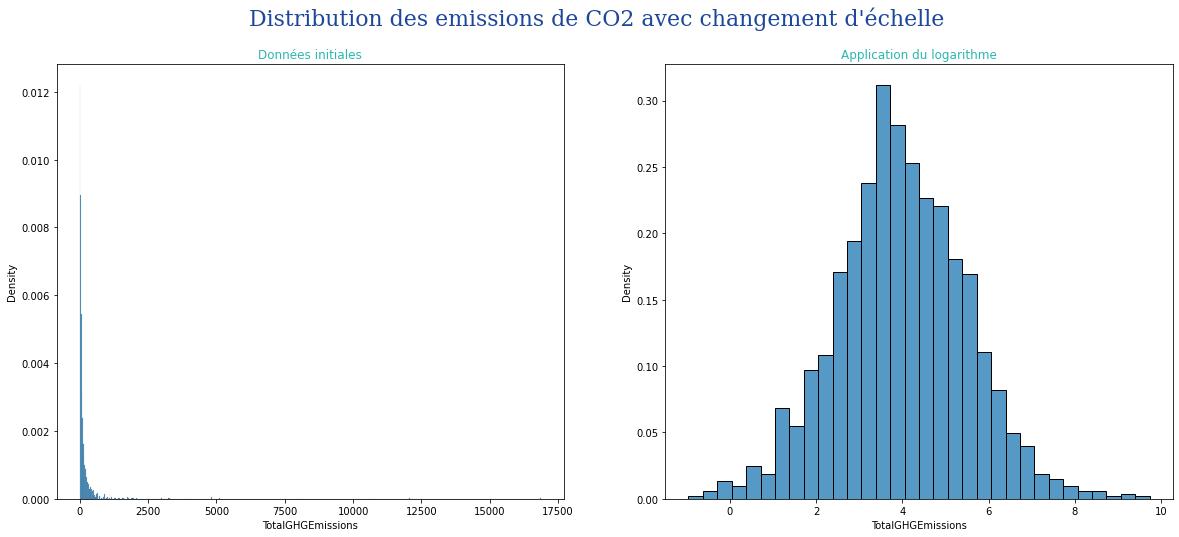

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer



font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              
             }

logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_log = logtransformer.transform(y)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=y, x='TotalGHGEmissions', stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0')
sns.histplot(data=Y_log, x='TotalGHGEmissions', stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme", color='#2cb7b0')
plt.suptitle("Distribution des emissions de CO2 avec changement d'échelle", fontdict=font_title, fontsize=22)
plt.show()



In [42]:

logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
log_x_train_num = logtransformer.transform(X_num)
feature_skew = X_num.skew()
log_feature_skew = log_x_train_num.skew()

(pd.concat([feature_skew, log_feature_skew], axis=1)
 .rename(columns={0: 'feature.skew()', 1: 'log(feature).skew()'})
 ).style.highlight_min(axis=1)

d:\users\asus\miniconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
d:\users\asus\miniconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,feature.skew(),log(feature).skew()
NumberofBuildings,13.056948,4.873100
NumberofFloors,5.882632,0.868124
PropertyGFATotal,4.862059,1.027461
BuildingAge,0.276627,-1.295994
TotalUseTypeNb,2.234092,0.608604
GFABuildRate,-2.438300,-3.502208
GFAParkRate,2.438300,nan
GFAPerBuilding,5.509271,0.978898
GFAPerFloor,9.437570,0.695341
harvesine_distance,0.815662,-0.625056


La transformation `np.log` a un effet de réduction de skew (absolute) de toutes les variables numériques sauf `GFABuildRate` `BuildingAge`.


En passant les données à **l'échelle logarithmique**, nous obtenons une distribution normale des données à prédire. Nous allons donc appliquer cette transformation dans notre pipeline grâce à la fonction **TransformedTargetRegressor de la librairie Sklearn.**

La fonction **inverse (exp)** sera donc passée dans les prédictions.


# <font color="#337da4" id="section_2">2. Modèle Baseline : Régression linéaire multivariée</font>

A présent, nous allons créer un modèle baseline pour évaluer les performances de nos futurs modèles et vérifier qu'ils améliore les prédictions. Pour cette baseline, nous utiliserons une régression linéaire multivariée.


In [43]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as r2 # evaluation metric
from sklearn.feature_selection import SelectKBest,f_regression, f_classif, mutual_info_regression
from sklearn import set_config
set_config(display='diagram')


param_mlr = {'select__k': np.arange(1,X_test.shape[1]+1,2),
             'select__score_func': [mutual_info_regression, f_regression],
             "model__regressor__fit_intercept": [True, False]}
pipe = Pipeline([
('select', SelectKBest()),
('model', TransformedTargetRegressor(
                                regressor=LinearRegression(), 
                                func=np.log, 
                                inverse_func=np.exp))])
mlr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_mlr', GridSearchCV(pipe,
                            param_grid=param_mlr,
                            cv=5,
                            scoring=('r2'),
                            
                            return_train_score = True,
                            
                            n_jobs = -1))])



Nous allons calculer la principale métrique pour évaluer nos modèles :

   - R² : Coefficient de détermination, carré du coefficient de corrélation linéaire.



In [44]:
#Retour des meilleurs scores  R2
#Stockage du dataframe des resultats du modèle
def model_scores(pip,step):
    df_results = pd.DataFrame.from_dict(pip.named_steps[step].cv_results_)
    best_r2 = np.mean(df_results[df_results.rank_test_score == 1]['mean_test_score'])
    best_params = pip.named_steps[step].best_params_
    training_time = round((np.mean(df_results.mean_fit_time)*X_train.shape[0]),2)
    print("Meilleur Score R2 : {}\nMeilleurs paramètres : {}\nTemps moyen d'entrainement : {}s"\
         .format( round(best_r2,3), best_params, training_time))
    return df_results

On affiche les scores de la **GridSearch avec validation croisée pour la variable TotalGHGEmissions** :


In [45]:
#Entrainement sur les 2 variables à expliquer :
GHG_mlr_model = mlr_grid_cv.fit(X_train, y_train['TotalGHGEmissions'])


In [46]:
GHG_mlr_results = model_scores(GHG_mlr_model, 'grid_search_mlr')

Meilleur Score R2 : -1.062
Meilleurs paramètres : {'model__regressor__fit_intercept': True, 'select__k': 1, 'select__score_func': <function mutual_info_regression at 0x0000020099425280>}
Temps moyen d'entrainement : 102.61s


et les scores pour la variable SiteEnergyUse(kBtu) :


In [47]:
SEU_mlr_model = mlr_grid_cv.fit(X_train, y_train['SiteEnergyUse(kBtu)'])


In [48]:
SEU_mlr_results = model_scores(GHG_mlr_model, 'grid_search_mlr')

Meilleur Score R2 : -25.436
Meilleurs paramètres : {'model__regressor__fit_intercept': True, 'select__k': 1, 'select__score_func': <function f_regression at 0x000002009940BB80>}
Temps moyen d'entrainement : 86.45s


Tous les résultats des GridSearchCV sont stockés dans un DataFrame pour chaque variable à prédire :


In [49]:
GHG_mlr_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__regressor__fit_intercept,param_select__k,param_select__score_func,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.303056,1.452941e-01,0.000595,1.987458e-04,True,1,<function mutual_info_regression at 0x00000200...,"{'model__regressor__fit_intercept': True, 'sel...",-2.423891e+00,4.420261e-01,...,-1.061682e+00,1.231966e+00,1,-5.840859e+00,-2.252439e+00,-8.398894e+00,-4.339126e+00,-4.188425e+00,-5.003948e+00,2.044698e+00
1,0.026486,3.814435e-02,0.000496,3.162980e-07,True,1,<function f_regression at 0x000002009940BB80>,"{'model__regressor__fit_intercept': True, 'sel...",-2.101589e+01,4.420261e-01,...,-2.395116e+01,3.633147e+01,2,-6.252465e+00,-2.252439e+00,-5.025772e+00,-3.657093e+00,-1.010771e+01,-5.459096e+00,2.681667e+00
2,0.137391,2.017703e-02,0.000794,2.430236e-04,True,3,<function mutual_info_regression at 0x00000200...,"{'model__regressor__fit_intercept': True, 'sel...",-8.386014e+00,-7.183586e+03,...,-1.440714e+03,2.871438e+03,11,-3.164192e+02,-2.524108e+01,-7.869023e+02,-9.257887e+01,-1.848137e+02,-2.811910e+02,2.710566e+02
3,0.005257,5.310200e-03,0.000794,2.431021e-04,True,3,<function f_regression at 0x000002009940BB80>,"{'model__regressor__fit_intercept': True, 'sel...",-1.153897e+01,-7.183586e+03,...,-1.444989e+03,2.869318e+03,12,-7.662267e+02,-2.524108e+01,-7.869023e+02,-5.869355e+02,-5.931432e+02,-5.516897e+02,2.762100e+02
4,0.163283,2.900555e-02,0.000794,2.430625e-04,True,5,<function mutual_info_regression at 0x00000200...,"{'model__regressor__fit_intercept': True, 'sel...",-6.587035e+00,-1.687039e+03,...,-3.411852e+02,6.729336e+02,8,-2.563851e+02,-1.127639e+01,-2.215467e+02,-8.989376e+01,-1.548502e+02,-1.467904e+02,8.861799e+01
5,0.008531,1.210232e-02,0.000694,2.427900e-04,True,5,<function f_regression at 0x000002009940BB80>,"{'model__regressor__fit_intercept': True, 'sel...",-7.535902e+01,-1.882648e+03,...,-3.923795e+02,7.456868e+02,9,-2.014752e+02,-1.326721e+01,-4.248729e+01,-2.603745e+01,-3.936196e+02,-1.353773e+02,1.459813e+02
6,0.164771,2.229745e-02,0.000595,1.984597e-04,True,7,<function mutual_info_regression at 0x00000200...,"{'model__regressor__fit_intercept': True, 'sel...",-5.555201e+00,-2.606710e+02,...,-5.506578e+01,1.028211e+02,3,-4.041992e+02,-5.022269e+00,-4.072195e+02,-1.944383e+01,-2.288287e+02,-2.129427e+02,1.762088e+02
7,0.002777,2.428488e-04,0.000496,5.309834e-07,True,7,<function f_regression at 0x000002009940BB80>,"{'model__regressor__fit_intercept': True, 'sel...",-1.316686e+02,-7.022680e+02,...,-1.703562e+02,2.704211e+02,6,-2.086999e+01,-1.216497e+00,-4.233195e+01,-9.692309e+00,-1.404186e+01,-1.763052e+01,1.389941e+01
8,0.146221,1.777683e-02,0.000694,2.427514e-04,True,9,<function mutual_info_regression at 0x00000200...,"{'model__regressor__fit_intercept': True, 'sel...",-1.785493e+03,-5.242350e+02,...,-4.646547e+02,6.904147e+02,10,-3.084244e+01,-9.242065e+00,-7.771135e+01,-1.677536e+01,-1.924862e+01,-3.076397e+01,2.447668e+01
9,0.002778,3.967643e-04,0.007043,1.260008e-02,True,9,<function f_regression at 0x000002009940BB80>,"{'model__regressor__fit_intercept': True, 'sel...",-4.597728e+02,-3.564277e+02,...,-1.723338e+02,1.958112e+02,7,-1.337737e+01,-1.229369e+00,-1.731012e+01,-6.809729e+00,-5.899928e+00,-8.925303e+00,5.709326e+00


In [50]:
SEU_mlr_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler(unit_variance=True))]),
                                                  ['harvesine_distance',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'BuildingAge',
                                                   'TotalUseTypeNb',
                                                   'GFAPerBuilding',
                                                   'GFAPerFloor']),
                                                 ('cat',
                                                  Pipeline(steps=[('imput...
                                                         TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                                    inverse_func=<ufunc 'exp'>,
                                                                                    regressor=LinearRegression()))]),
                              n_jobs=-1,
                              param_grid={'model__regressor__fit_intercept': [True,
                                                                              False],
                                          'select__k': array([ 1,  3,  5,  7,  9, 11]),
                                          'select__score_func': [<function mutual_info_regression at 0x0000020099425280>,
                                                                 <function f_regression at 0x000002009940BB80>]},
                              return_train_score=True, scoring='r2'))])

## SANS Log

In [51]:
from sklearn.ensemble import RandomForestRegressor
param_mlr = {'select__k': np.arange(1,X_test.shape[1]+1,2),
             'select__score_func': [mutual_info_regression, f_regression],
             "model__fit_intercept": [True, False]}
pipe = Pipeline([
('select', SelectKBest()),
('model', LinearRegression())])
mlr_grid_cv_nolog = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_mlr_nolog', GridSearchCV(pipe,
                            param_grid=param_mlr,
                            cv=5,
                            scoring=('r2'),
                            refit="r2",
                            return_train_score = True,
                            
                            n_jobs = -1))])

In [52]:
#Entrainement sur les 2 variables à expliquer :
GHG_mlr_model_nolog = mlr_grid_cv_nolog.fit(X_train, y_train['TotalGHGEmissions'])


In [53]:
GHG_mlr_results_nolog = model_scores(GHG_mlr_model_nolog, 'grid_search_mlr_nolog')

Meilleur Score R2 : 0.501
Meilleurs paramètres : {'model__fit_intercept': False, 'select__k': 5, 'select__score_func': <function mutual_info_regression at 0x0000020099425280>}
Temps moyen d'entrainement : 77.24s


In [54]:
SEU_mlr_model_nolog = mlr_grid_cv_nolog.fit(X_train, y_train['SiteEnergyUse(kBtu)'])


In [55]:
SEU_mlr_results_nolog = model_scores(GHG_mlr_model_nolog, 'grid_search_mlr_nolog')

Meilleur Score R2 : 0.538
Meilleurs paramètres : {'model__fit_intercept': False, 'select__k': 3, 'select__score_func': <function mutual_info_regression at 0x0000020099425280>}
Temps moyen d'entrainement : 86.85s


La transformation en log a fait chuté le R² de notre modèle linéaire multivarié. Nous choisirons la forme non transformée.
Nous avons à présent nos métriques de départ obtenues avec notre modèle de régression linéaire multivarié servant de baseline. Nous allons réaliser nos premières modélisations en utilisant des modèles linéaires.


# <font color="#337da4" id="section_3">3. Modèle linéaires : ElasticNet et SVR</font>
   ## <font color="#337da4" id="section_3_1">3.1. Modèle ElasticNet</font>
**Explication du modèle :**

In [56]:
param_eNet = {#'select__k': np.arange(1,X_test.shape[1]+1,2),
              #'select__score_func': [mutual_info_regression, f_regression],
              "model__regressor__max_iter": [10, 100, 1000],
              "model__regressor__alpha": np.logspace(-2, 2, num=5),
              "model__regressor__l1_ratio": np.arange(0.0, 1.1, 0.1)}
pipe = Pipeline([
#('select', SelectKBest()),
('model', TransformedTargetRegressor(
                                regressor=ElasticNet(), 
                                func=np.log, 
                                inverse_func=np.exp))])
eNet_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_enet', GridSearchCV(pipe,
                            param_grid=param_eNet,
                            cv=5,
                            scoring=('r2'),
                            
                            return_train_score = True,
                            
                            n_jobs = -1))])

In [57]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
GHG_eNet_model = eNet_grid_cv.fit(X_train, y_train['TotalGHGEmissions'])


In [58]:
GHG_eNet_results_grid = model_scores(GHG_eNet_model, 'grid_search_enet')

Meilleur Score R2 : 0.309
Meilleurs paramètres : {'model__regressor__alpha': 100.0, 'model__regressor__l1_ratio': 0.8, 'model__regressor__max_iter': 10}
Temps moyen d'entrainement : 11.2s


In [ ]:
SEU_eNet_model = eNet_grid_cv.fit(X_train, y_train['SiteEnergyUse(kBtu)'])


In [60]:
SEU_eNet_results = model_scores(SEU_eNet_model, 'grid_search_enet')

Meilleur Score R2 : -28.048
Meilleurs paramètres : {'model__regressor__alpha': 10.0, 'model__regressor__l1_ratio': 0.0, 'model__regressor__max_iter': 1000}
Temps moyen d'entrainement : 9.6s


## SANS Log

In [61]:
param_eNet = {#'select__k': np.arange(1,X_test.shape[1]+1,2),
              #'select__score_func': [mutual_info_regression, f_regression],
              "model__max_iter": [100, 1000, 10000],
              "model__alpha": np.logspace(-1, 3, num=5),
              "model__l1_ratio": np.arange(0.0, 1.1, 0.1)}
pipe = Pipeline([
#('select', SelectKBest()),
('model', ElasticNet())])
eNet_grid_cv_nolog = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_enet_nolog', GridSearchCV(pipe,
                            param_grid=param_eNet,
                            cv=5,
                            scoring=('r2'),
                            
                            return_train_score = True,
                            
                            n_jobs = -1))])

In [62]:

GHG_eNet_model_nolog = eNet_grid_cv_nolog.fit(X_train, y_train['TotalGHGEmissions'])


In [63]:
GHG_eNet_results_grid_nolog = model_scores(GHG_eNet_model_nolog, 'grid_search_enet_nolog')

Meilleur Score R2 : 0.39
Meilleurs paramètres : {'model__alpha': 1.0, 'model__l1_ratio': 0.8, 'model__max_iter': 1000}
Temps moyen d'entrainement : 15.13s


In [ ]:
SEU_eNet_model_nolog = eNet_grid_cv_nolog.fit(X_train, y_train['SiteEnergyUse(kBtu)'])


In [65]:
SEU_eNet_results_nolog = model_scores(SEU_eNet_model_nolog, 'grid_search_enet_nolog')

Meilleur Score R2 : 0.48
Meilleurs paramètres : {'model__alpha': 1.0, 'model__l1_ratio': 0.8, 'model__max_iter': 100}
Temps moyen d'entrainement : 24.41s


Suite à cette première modélisation par ElasticNet, le modèle sans transformation log est bien meilleur cependant le R² à baissé pour les prédictions de la consommation d'énergie et les émissions de CO2 comparé à la baseline. Nous allons à présent tester un second modèle linéaire : SVR.


## <font color="#337da4" id="section_3_2">3.2. Modèle Support Vector Regression (SVR)</font>
**Explication du modèle :**

In [66]:
from sklearn.svm import LinearSVR

param_svr = {'select__k': np.arange(1,X_test.shape[1]+1,2),
             'model__regressor__C' : np.logspace(-4, 0, 5),
             'model__regressor__epsilon' : [0, 0.01, 0.1, 0.5, 1, 2],
             'model__regressor__loss' : ["epsilon_insensitive","squared_epsilon_insensitive"],
             'model__regressor__max_iter': [10, 100, 1000]}
pipe = Pipeline([
('select', SelectKBest()),
('model', TransformedTargetRegressor(
                                regressor=LinearSVR(), 
                                func=np.log, 
                                inverse_func=np.exp))])
svr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_svr', GridSearchCV(pipe,
                            param_grid=param_svr,
                            cv=5,
                            scoring=('r2'),
                            
                            return_train_score = True,
                            
                            n_jobs = -1))])

In [ ]:
GHG_svr_model = svr_grid_cv.fit(X_train, y_train['TotalGHGEmissions'])


In [68]:
GHG_svr_results = model_scores(GHG_svr_model, 'grid_search_svr')

Meilleur Score R2 : -11595.362
Meilleurs paramètres : {'model__regressor__C': 0.0001, 'model__regressor__epsilon': 2, 'model__regressor__loss': 'squared_epsilon_insensitive', 'model__regressor__max_iter': 1000, 'select__k': 1}
Temps moyen d'entrainement : 154.79s


In [ ]:
SEU_svr_model = svr_grid_cv.fit(X_train, y_train['SiteEnergyUse(kBtu)'])


In [70]:
SEU_svr_results = model_scores(SEU_svr_model, 'grid_search_svr')

Meilleur Score R2 : -0.169
Meilleurs paramètres : {'model__regressor__C': 0.0001, 'model__regressor__epsilon': 0, 'model__regressor__loss': 'epsilon_insensitive', 'model__regressor__max_iter': 10, 'select__k': 5}
Temps moyen d'entrainement : 142.51s


## SANS Log

In [71]:
from sklearn.svm import LinearSVR

param_svr = {'select__k': np.arange(1,X_test.shape[1]+1,2),
             'model__C' : np.logspace(-4, 0, 5),
             'model__epsilon' : [0, 0.01, 0.1, 0.5, 1, 2],
             'model__loss' : ["epsilon_insensitive","squared_epsilon_insensitive"],
             'model__max_iter': [10, 100, 1000]}
pipe = Pipeline([
('select', SelectKBest()),
('model', LinearSVR())])
svr_grid_cv_nolog = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_svr_nolog', GridSearchCV(pipe,
                            param_grid=param_svr,
                            cv=5,
                            scoring=('r2'),
                            
                            return_train_score = True,
                            
                            n_jobs = -1))])

In [ ]:
GHG_svr_model_nolog = svr_grid_cv_nolog.fit(X_train, y_train['TotalGHGEmissions'])


In [73]:
GHG_svr_results_nolog = model_scores(GHG_svr_model_nolog, 'grid_search_svr_nolog')

Meilleur Score R2 : 0.538
Meilleurs paramètres : {'model__C': 0.1, 'model__epsilon': 1, 'model__loss': 'squared_epsilon_insensitive', 'model__max_iter': 100, 'select__k': 11}
Temps moyen d'entrainement : 143.97s


In [ ]:
SEU_svr_model_nolog = svr_grid_cv_nolog.fit(X_train, y_train['SiteEnergyUse(kBtu)'])


In [75]:
SEU_svr_results_nolog = model_scores(SEU_svr_model_nolog, 'grid_search_svr_nolog')

Meilleur Score R2 : 0.382
Meilleurs paramètres : {'model__C': 0.0001, 'model__epsilon': 0.1, 'model__loss': 'squared_epsilon_insensitive', 'model__max_iter': 100, 'select__k': 7}
Temps moyen d'entrainement : 150.89s


Sur ce modèle SVR linéaire, les métriques sont moins bonnes pour la  variable **SiteEnergyUse(kBtu)** cependant pour la variable **TotalGHGEmissions le R² s'est un peu amélioré** comparé à la baseline.

Nous allons à présent nous pencher sur des **modèles non-linéaires.**

# <font color="#337da4" id="section_4">4. Modèle non-linéaires : XGBoost et RandomForestRegressor</font>
## <font color="#337da4" id="section_4_1">4.1. Modèle RandomForestRegressor</font>
**Explication du modèle :**

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
param_rfr = {'select__k': np.arange(1,X_test.shape[1]+1,2),
             'select__score_func': [mutual_info_regression, f_regression],
             'model__regressor__max_features' : ['sqrt', 'log2'],
             'model__regressor__max_depth': [5, 15, 25, 50],
             'model__regressor__min_samples_split': [2, 5, 10],
             'model__regressor__bootstrap' : [True, False],
             'model__regressor__min_samples_leaf': [1,2,5,10]}
pipe = Pipeline([
('select', SelectKBest()),
('model', TransformedTargetRegressor(
                                regressor=RandomForestRegressor(random_state=42), 
                                func=np.log, 
                                inverse_func=np.exp))])
rfr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_rfr', GridSearchCV(pipe,
                            param_grid=param_rfr,
                            cv=5,
                            scoring=('r2'),
                            refit="r2",
                            return_train_score = True,
                            n_jobs = -1))])

In [77]:
GHG_rfr_model = rfr_grid_cv.fit(X_train, y_train['TotalGHGEmissions'])


In [78]:
GHG_rfr_results = model_scores(GHG_rfr_model, 'grid_search_rfr')


Meilleur Score R2 : 0.611
Meilleurs paramètres : {'model__regressor__bootstrap': False, 'model__regressor__max_depth': 5, 'model__regressor__max_features': 'sqrt', 'model__regressor__min_samples_leaf': 1, 'model__regressor__min_samples_split': 2, 'select__k': 3, 'select__score_func': <function f_regression at 0x000002009940BB80>}
Temps moyen d'entrainement : 360.62s


In [79]:
np.seterr(divide='warn', invalid='warn')
SEU_rfr_model = rfr_grid_cv.fit(X_train, y_train['SiteEnergyUse(kBtu)'])


In [80]:
SEU_rfr_results = model_scores(SEU_rfr_model, 'grid_search_rfr')

Meilleur Score R2 : 0.641
Meilleurs paramètres : {'model__regressor__bootstrap': False, 'model__regressor__max_depth': 15, 'model__regressor__max_features': 'log2', 'model__regressor__min_samples_leaf': 2, 'model__regressor__min_samples_split': 2, 'select__k': 3, 'select__score_func': <function f_regression at 0x000002009940BB80>}
Temps moyen d'entrainement : 360.09s


## SANS Log

In [81]:
from sklearn.ensemble import RandomForestRegressor
param_rfr = {'select__k': np.arange(1,X_test.shape[1]+1,2),
             'select__score_func': [mutual_info_regression, f_regression],
             'model__max_features' : ['sqrt', 'log2'],
             'model__max_depth': [5, 15, 25, 50],
             'model__min_samples_split': [2, 5, 10],
             'model__bootstrap' : [True, False],
             'model__min_samples_leaf': [1,2,5,10]}
pipe = Pipeline([
('select', SelectKBest()),
('model', RandomForestRegressor(random_state=42))])
rfr_grid_cv_nolog = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_rfr_nolog', GridSearchCV(pipe,
                            param_grid=param_rfr,
                            cv=5,
                            scoring=('r2'),
                            refit="r2",
                            return_train_score = True,
                            n_jobs = -1))])

In [82]:
GHG_rfr_model_nolog = rfr_grid_cv_nolog.fit(X_train, y_train['TotalGHGEmissions'])


In [83]:
GHG_rfr_results_nolog = model_scores(GHG_rfr_model_nolog, 'grid_search_rfr_nolog')

Meilleur Score R2 : 0.62
Meilleurs paramètres : {'model__bootstrap': False, 'model__max_depth': 5, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'select__k': 7, 'select__score_func': <function f_regression at 0x000002009940BB80>}
Temps moyen d'entrainement : 376.02s


In [84]:
SEU_rfr_model_nolog = rfr_grid_cv_nolog.fit(X_train, y_train['SiteEnergyUse(kBtu)'])


In [85]:
SEU_rfr_results_nolog = model_scores(SEU_rfr_model_nolog, 'grid_search_rfr_nolog')

Meilleur Score R2 : 0.657
Meilleurs paramètres : {'model__bootstrap': False, 'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'select__k': 11, 'select__score_func': <function f_regression at 0x000002009940BB80>}
Temps moyen d'entrainement : 379.02s


## <font color="#337da4" id="section_4_2">4.2 Modèle XGBoost *(eXtreme Gradient Boosting)*</font>
**Explication du modèle :**

In [92]:
import xgboost as xgb
param_xgb = {'select__k': np.arange(1,X_test.shape[1]+1,2),
             'select__score_func': [mutual_info_regression, f_regression],
             'model__regressor__learning_rate' : [0.001, 0.01, 0.1, 0.2, 0,3],
             'model__regressor__gamma': [0, 0.25, 0.5, 1.0],
             'model__regressor__max_depth': [6, 10, 15, 20],
             'model__regressor__min_child_weight' : [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
             'model__regressor__n_estimators': [25, 50, 100, 500, 1000]}
pipe = Pipeline([
('select', SelectKBest()),
('model', TransformedTargetRegressor(
                                regressor=xgb.XGBRegressor(gpu_id =-1),
                                func=np.log, 
                                inverse_func=np.exp))])
xgb_rand_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('rand_search_xgb', RandomizedSearchCV(pipe,
                            param_distributions=param_xgb,
                            cv=5,
                            n_iter=20,
                            scoring=('r2'),
                            refit="r2",
                            return_train_score = True,
                            n_jobs = -1))])

In [ ]:
GHG_xgb_model = xgb_rand_cv.fit(X_train, y_train['TotalGHGEmissions'])


In [94]:
GHG_xgb_results = model_scores(GHG_xgb_model, 'rand_search_xgb')

Meilleur Score R2 : 0.51
Meilleurs paramètres : {'select__score_func': <function f_regression at 0x000002009940BB80>, 'select__k': 9, 'model__regressor__n_estimators': 500, 'model__regressor__min_child_weight': 1.0, 'model__regressor__max_depth': 6, 'model__regressor__learning_rate': 0.2, 'model__regressor__gamma': 0.5}
Temps moyen d'entrainement : 1297.43s


In [ ]:
SEU_xgb_model = xgb_rand_cv.fit(X_train, y_train['SiteEnergyUse(kBtu)'])


In [96]:
SEU_xgb_results = model_scores(SEU_xgb_model, 'rand_search_xgb')

Meilleur Score R2 : 0.57
Meilleurs paramètres : {'select__score_func': <function f_regression at 0x000002009940BB80>, 'select__k': 5, 'model__regressor__n_estimators': 50, 'model__regressor__min_child_weight': 7.0, 'model__regressor__max_depth': 6, 'model__regressor__learning_rate': 0.2, 'model__regressor__gamma': 0.5}
Temps moyen d'entrainement : 463.02s


## SANS Log

In [97]:
import xgboost as xgb
param_xgb = {'select__k': np.arange(1,X_test.shape[1]+1,2),
             'select__score_func': [mutual_info_regression, f_regression],
             'model__learning_rate' : [0.001, 0.01, 0.1, 0.2, 0,3],
             'model__gamma': [0, 0.25, 0.5, 1.0],
             'model__max_depth': [6, 10, 15, 20],
             'model__min_child_weight' : [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
             'model__n_estimators': [25, 50, 100, 500, 1000]}
pipe = Pipeline([
('select', SelectKBest()),
('model', xgb.XGBRegressor(gpu_id =-1))])
xgb_rand_cv_nolog = Pipeline([
    ('preprocessor', preprocessor),
    ('rand_search_xgb_nolog', RandomizedSearchCV(pipe,
                            param_distributions=param_xgb,
                            cv=5,
                            n_iter=20,
                            scoring=('r2'),
                            refit="r2",
                            return_train_score = True,
                            n_jobs = -1))])

In [ ]:
GHG_xgb_model_nolog = xgb_rand_cv_nolog.fit(X_train, y_train['TotalGHGEmissions'])


In [99]:
GHG_xgb_results_nolog = model_scores(GHG_xgb_model_nolog, 'rand_search_xgb_nolog')

Meilleur Score R2 : 0.548
Meilleurs paramètres : {'select__score_func': <function f_regression at 0x000002009940BB80>, 'select__k': 5, 'model__n_estimators': 25, 'model__min_child_weight': 1.0, 'model__max_depth': 10, 'model__learning_rate': 0.1, 'model__gamma': 0.5}
Temps moyen d'entrainement : 1253.8s


In [ ]:
SEU_xgb_model_nolog = xgb_rand_cv_nolog.fit(X_train, y_train['SiteEnergyUse(kBtu)'])


In [101]:
SEU_xgb_results_nolog = model_scores(SEU_xgb_model_nolog, 'rand_search_xgb_nolog')

Meilleur Score R2 : 0.572
Meilleurs paramètres : {'select__score_func': <function f_regression at 0x000002009940BB80>, 'select__k': 9, 'model__n_estimators': 1000, 'model__min_child_weight': 5.0, 'model__max_depth': 15, 'model__learning_rate': 0.1, 'model__gamma': 1.0}
Temps moyen d'entrainement : 2682.01s



- Le modèle XGBoost non-linéaire avec transformation Log est plus performant que sans transformation.
- Le modèle XGBoost non-linéaire avec transformation Log a des niveaux de performances de prédiction sur les 2 variables légèrement inférieurs au modèle RandomForestRegressor sans transformation Log mais nous avons dû utiliser le GPU pour accélerer le temps de calcul.

# <font color="#337da4" id="section_5">5. Sélection des meilleurs modèles</font>

Sur les 4 modèles testés (avec/sans transformation Log) ,les modèles linéaires retournent de moins bonnes métriques en général. Si nous prenons en considération le score R², qui aura du sens sur les modèles linéaires et non-linéaires, les algorithmes XGBoost et RandomForestRegressor offrent des performances à peu près similaires pour la qualité des prédictions mais les temps de calculs sont meilleurs sur le modèles **RandomForestRegressor.**

Nous allons donc regarder de plus près les résultats obtenus sur nos 2 variables à prédire avec les différents modèles :


## <font color="#337da4" id="section_5_1">5.1. Modèle de prédiction des émissions de CO2</font>

In [102]:
metrics = ['mean_fit_time', 'mean_score_time',
           'mean_test_score',
           'mean_train_score']
GHG_compare_metrics = pd.concat([pd.DataFrame(GHG_rfr_results.iloc[np.argmax(GHG_rfr_results["mean_test_score"])][metrics].values, columns=['RandomForestLog'],index=metrics),
                                 pd.DataFrame(GHG_rfr_results_nolog.iloc[np.argmax(GHG_rfr_results_nolog["mean_test_score"])][metrics].values, columns=['RandomForest'],index=metrics),
           pd.DataFrame(GHG_xgb_results.iloc[np.argmax(GHG_xgb_results["mean_test_score"])][metrics].values, columns=['XGBoostLog'],index=metrics),
                                 pd.DataFrame(GHG_xgb_results_nolog.iloc[np.argmax(GHG_xgb_results_nolog["mean_test_score"])][metrics].values, columns=['XGBoost'],index=metrics),
           pd.DataFrame(GHG_svr_results.iloc[np.argmax(GHG_svr_results["mean_test_score"])][metrics].values, columns=['LinearSVRLog'],index=metrics),
                                 pd.DataFrame(GHG_svr_results_nolog.iloc[np.argmax(GHG_svr_results_nolog["mean_test_score"])][metrics].values, columns=['LinearSVR'],index=metrics),
           pd.DataFrame(GHG_eNet_results_grid.iloc[np.argmax(GHG_eNet_results_grid["mean_test_score"])][metrics].values, columns=['ElasticNetLog'],index=metrics),
                                 pd.DataFrame(GHG_eNet_results_grid_nolog.iloc[np.argmax(GHG_eNet_results_grid_nolog["mean_test_score"])][metrics].values, columns=['ElasticNet'],index=metrics),
           pd.DataFrame(GHG_mlr_results.iloc[np.argmax(GHG_mlr_results["mean_test_score"])][metrics].values, columns=['LinearRegressionLog'],index=metrics),
                                 pd.DataFrame(GHG_mlr_results_nolog.iloc[np.argmax(GHG_mlr_results_nolog["mean_test_score"])][metrics].values, columns=['LinearRegression'],index=metrics)

          ], axis=1)
GHG_final_metrics_compare = pd.DataFrame(columns=metrics, 
                                     index=['RandomForestLog','RandomForest',
                                            'XGBoostLog','XGBoost',
                                            'LinearSVRLog','LinearSVR',
                                            'ElasticNetLog','ElasticNet',
                                            'LinearRegressionLog','LinearRegression'
                                            ])
for m in metrics:
    GHG_final_metrics_compare[m] = GHG_compare_metrics.loc[m]

In [103]:
GHG_final_metrics_compare

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
RandomForestLog,0.158918,0.015971,0.611273,0.552043
RandomForest,0.189967,0.018054,0.620412,0.95857
XGBoostLog,1.184644,0.002976,0.510489,0.864697
XGBoost,0.090173,0.002877,0.548248,0.94249
LinearSVRLog,0.106342,0.002083,-11595.361924,-8011.175645
LinearSVR,0.127372,0.000793,0.538306,0.205383
ElasticNetLog,0.003174,0.000596,0.308662,0.291582
ElasticNet,0.003274,0.000595,0.389854,0.539319
LinearRegressionLog,0.303056,0.000595,-1.061682,-5.003948
LinearRegression,0.112691,0.003472,0.501282,0.487129


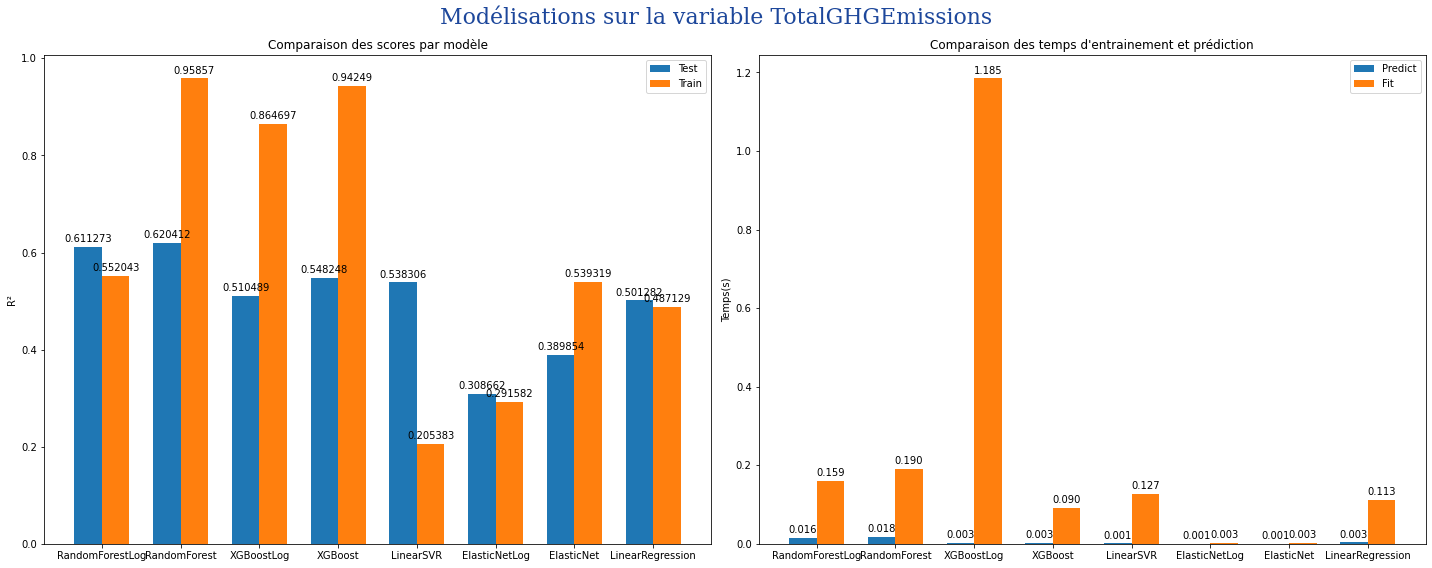

In [104]:
#On élimine le modèle SVR de cette représentation car hors normes
GHG_final_metrics_compare = GHG_final_metrics_compare[(GHG_final_metrics_compare.index != 'LinearSVRLog') & (GHG_final_metrics_compare.index != "LinearRegressionLog")]
x = np.arange(len(GHG_final_metrics_compare.index))
width = 0.35

fig, ax = plt.subplots(1,2,figsize=(20,8), sharey=False, sharex=False)

scores1 = ax[0].bar(x - width/2, GHG_final_metrics_compare['mean_test_score'], width, label='Test')
scores2 = ax[0].bar(x + width/2, GHG_final_metrics_compare['mean_train_score'], width, label='Train')
ax[0].set_ylabel('R²')
ax[0].set_title('Comparaison des scores par modèle')
ax[0].set_xticks(x)
ax[0].set_xticklabels(GHG_final_metrics_compare.index)
ax[0].legend()
ax[0].bar_label(scores1, padding=3)
ax[0].bar_label(scores2, padding=3)

times1 = ax[1].bar(x - width/2, GHG_final_metrics_compare['mean_score_time'], width, label='Predict')
times2 = ax[1].bar(x + width/2, GHG_final_metrics_compare['mean_fit_time'], width, label='Fit')
ax[1].set_ylabel('Temps(s)')
ax[1].set_title("Comparaison des temps d'entrainement et prédiction")
ax[1].set_xticks(x)
ax[1].set_xticklabels(GHG_final_metrics_compare.index)
ax[1].legend()
ax[1].bar_label(times1, padding=3, fmt='%.3f')
ax[1].bar_label(times2, padding=3, fmt='%.3f')

plt.suptitle("Modélisations sur la variable TotalGHGEmissions", fontdict=font_title, fontsize=22)
fig.tight_layout()

plt.show()

Avec la projection graphique ci-dessus, on constate que les modèles RandomForestRegressor offrent le meilleur compromis score / temps. Il sont en effet meilleurs en terme de score R² et également bien plus rapide que les modèles XGBoost.

Les modèles retenus pour la modélisation de la variable TotalGHGEmissions sont donc les **modèles RandomForestRegressor.** 

Nous allons analyser la **learning curve** des modèles **RandomForestRegressor** pour déterminer lequel choisir:


Learning curve permet de voir si les données sont en overfitting (Variance élevée) ou en underfitting (Biais élevé)

### Avec Transformation Log

In [262]:
GHG_rfr_model.named_steps["grid_search_rfr"].best_params_

{'model__regressor__bootstrap': False,
 'model__regressor__max_depth': 15,
 'model__regressor__max_features': 'log2',
 'model__regressor__min_samples_leaf': 2,
 'model__regressor__min_samples_split': 2,
 'select__k': 3,
 'select__score_func': <function sklearn.feature_selection._univariate_selection.f_regression(X, y, *, center=True)>}

In [224]:

pipe = Pipeline([
('select', SelectKBest(f_regression, k=3)),
('model', TransformedTargetRegressor(
                                regressor=RandomForestRegressor(bootstrap= False,
                                                               max_depth=15,
                                                               max_features='log2',
                                                               min_samples_leaf=2,
                                                               min_samples_split=2,
                                                               random_state=42), 
                                func=np.log, 
                                inverse_func=np.exp))])
rfr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_rfr',pipe)])
GHG_rfr_model_final = rfr_grid_cv.fit(X_train, y_train['TotalGHGEmissions'])


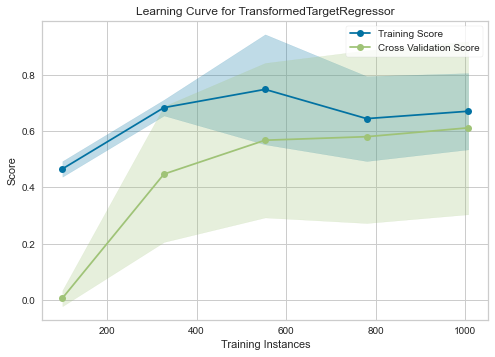

<AxesSubplot:title={'center':'Learning Curve for TransformedTargetRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [110]:
from yellowbrick.model_selection import LearningCurve

visualizer = LearningCurve(GHG_rfr_model_final, scoring='r2',cv=5)

visualizer.fit(X_train, y_train["TotalGHGEmissions"])        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

- Pour la taille des données d'entraînement **inférieure à 800**, la différence entre le training score et le validation score est bien plus grande. C'est le cas d'un **overfitting (Variance élevée)**
- Pour la taille des données d'entraînement **supérieure à 800, le modèle est meilleur**.

Dans notre cas, nous en avons plus de 800 donc notre modèle ne présente aucun cas d'overfitting ou underfitting.

Passons au modèle sans Transformation LOG

## Sans Transformation Log

In [112]:

pipe = Pipeline([
('select', SelectKBest(f_regression, k=11)),
('model', RandomForestRegressor(max_depth = 15,
                                bootstrap = False,
                                max_features='sqrt',
                                min_samples_leaf = 1,
                                min_samples_split = 2
                               ))])
rfr_grid_cv_nolog = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_rfr_nolog', pipe)])
GHG_rfr_model_nolog_final = rfr_grid_cv_nolog.fit(X_train, y_train['TotalGHGEmissions'])


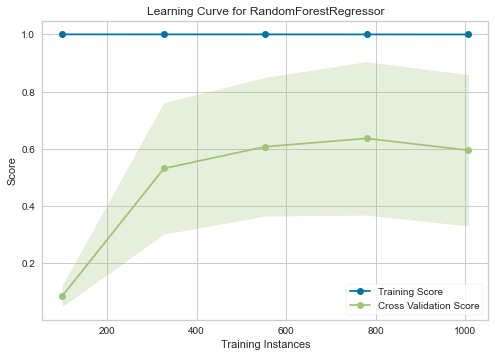

<AxesSubplot:title={'center':'Learning Curve for RandomForestRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [113]:
from yellowbrick.model_selection import LearningCurve

visualizer = LearningCurve(GHG_rfr_model_nolog_final, scoring='r2',cv=5)

visualizer.fit(X_train, y_train["TotalGHGEmissions"])        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

Ici, le modèle est moins performant que celui avec LOG car il est en overfitting. Avec plus de données nous pourrions avoir de meilleurs résultats.

Nous choisissons le modèle **RandomForestRegressor avec transformation LOG.**

Nous avons à présent défini notre modèle (avec LOG) pour la prédiction des émissions de CO2. Regardons à présent l'importance des variables dans notre modèle de forêts aléatoires :

In [133]:
filter = GHG_rfr_model_final.named_steps['grid_search_rfr'].named_steps['select'].get_support()
features = np.array(X_train.columns)
 

print("All features:")
print(features)
 

print("Selected best {}:".format(len(features[filter])))
print(features[filter])

All features:
['BuildingType' 'PrimaryPropertyType' 'Neighborhood'
 'LargestPropertyUseType' 'NumberofBuildings' 'NumberofFloors'
 'PropertyGFATotal' 'BuildingAge' 'TotalUseTypeNb' 'GFAPerBuilding'
 'GFAPerFloor' 'harvesine_distance']
Selected best 3:
['LargestPropertyUseType' 'GFAPerBuilding' 'harvesine_distance']


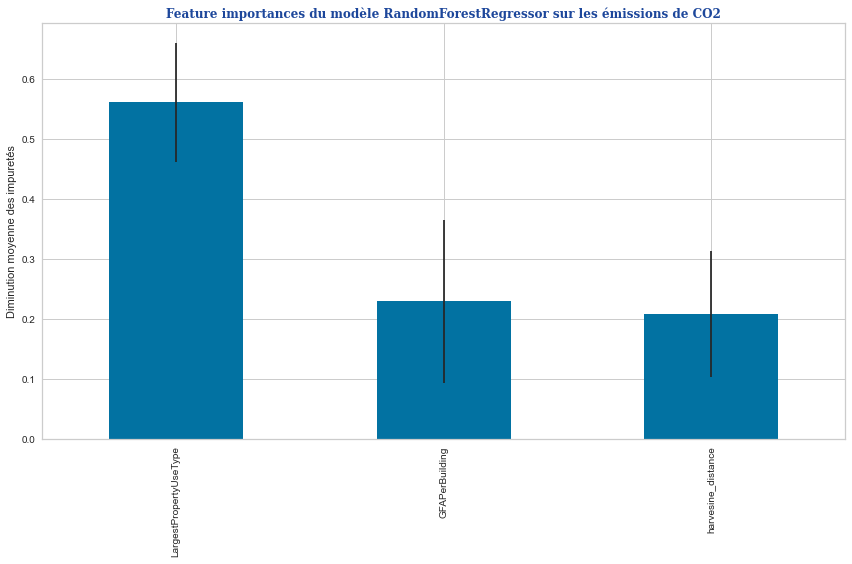

In [135]:
feature_importance = GHG_rfr_model_final.named_steps['grid_search_rfr'].named_steps['model'].regressor_.feature_importances_ 
features_names = features[filter]
std = np.std([
    tree.feature_importances_ for tree in GHG_rfr_model_final.named_steps['grid_search_rfr'].named_steps['model'].regressor_], axis=0)
df_feature_importance = pd.Series(feature_importance, index=features_names)

fig, ax = plt.subplots(figsize=(12,8))
df_feature_importance.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances du modèle RandomForestRegressor sur les émissions de CO2", fontdict=font_title)
ax.set_ylabel("Diminution moyenne des impuretés")
fig.tight_layout()

Tout d'abord, le feature selection automatique a selectionné 3 variables sur les 12 .
Les surfaces (GFA) de la propriété, le type d'utilisation principale et les coordonnées géographiques ont un poids plus important dans les décisions de notre modèle.

## <font color="#337da4" id="section_5_2">5.2. Modèle de prédiction des consommations d'énergie</font>

Cette fois encore, nous allons comparer les métriques obtenues sur les différents modèles :

In [136]:
metrics = ['mean_fit_time', 'mean_score_time',
           'mean_test_score',
           'mean_train_score']
SEU_compare_metrics = pd.concat([pd.DataFrame(SEU_rfr_results.iloc[np.argmax(SEU_rfr_results["mean_test_score"])][metrics].values, columns=['RandomForestLog'],index=metrics),
                                 pd.DataFrame(SEU_rfr_results_nolog.iloc[np.argmax(SEU_rfr_results_nolog["mean_test_score"])][metrics].values, columns=['RandomForest'],index=metrics),
           pd.DataFrame(SEU_xgb_results.iloc[np.argmax(SEU_xgb_results["mean_test_score"])][metrics].values, columns=['XGBoostLog'],index=metrics),
                                 pd.DataFrame(SEU_xgb_results_nolog.iloc[np.argmax(SEU_xgb_results_nolog["mean_test_score"])][metrics].values, columns=['XGBoost'],index=metrics),
           pd.DataFrame(SEU_svr_results.iloc[np.argmax(SEU_svr_results["mean_test_score"])][metrics].values, columns=['LinearSVRLog'],index=metrics),
                                 pd.DataFrame(SEU_svr_results_nolog.iloc[np.argmax(SEU_svr_results_nolog["mean_test_score"])][metrics].values, columns=['LinearSVR'],index=metrics),
           pd.DataFrame(SEU_eNet_results.iloc[np.argmax(SEU_eNet_results["mean_test_score"])][metrics].values, columns=['ElasticNetLog'],index=metrics),
                                 pd.DataFrame(SEU_eNet_results_nolog.iloc[np.argmax(SEU_eNet_results_nolog["mean_test_score"])][metrics].values, columns=['ElasticNet'],index=metrics),
           pd.DataFrame(SEU_mlr_results.iloc[np.argmax(SEU_mlr_results["mean_test_score"])][metrics].values, columns=['LinearRegressionLog'],index=metrics),
                                 pd.DataFrame(SEU_mlr_results_nolog.iloc[np.argmax(SEU_mlr_results_nolog["mean_test_score"])][metrics].values, columns=['LinearRegression'],index=metrics)

          ], axis=1)
SEU_final_metrics_compare = pd.DataFrame(columns=metrics, 
                                     index=['RandomForestLog','RandomForest',
                                            'XGBoostLog','XGBoost',
                                            'LinearSVRLog','LinearSVR',
                                            'ElasticNetLog','ElasticNet',
                                            'LinearRegressionLog','LinearRegression'
                                            ])
for m in metrics:
    SEU_final_metrics_compare[m] = SEU_compare_metrics.loc[m]
SEU_compare_metrics

,RandomForestLog,RandomForest,XGBoostLog,XGBoost,LinearSVRLog,LinearSVR,ElasticNetLog,ElasticNet,LinearRegressionLog,LinearRegression
mean_fit_time,0.18471,0.411282,0.089776,4.778655,0.124,0.094438,0.037894,0.02103,0.002579,0.13134
mean_score_time,0.015773,0.01617,0.003472,0.031149,0.000794,0.000496,0.000595,0.000497,0.000694,0.000596
mean_test_score,0.640611,0.657493,0.57032,0.571759,-0.169494,0.381646,-28.048032,0.47952,-25.436215,0.538118
mean_train_score,0.746474,0.999684,0.717743,0.999998,-0.125456,0.31428,-22.89216,0.605532,-23.451515,0.517052


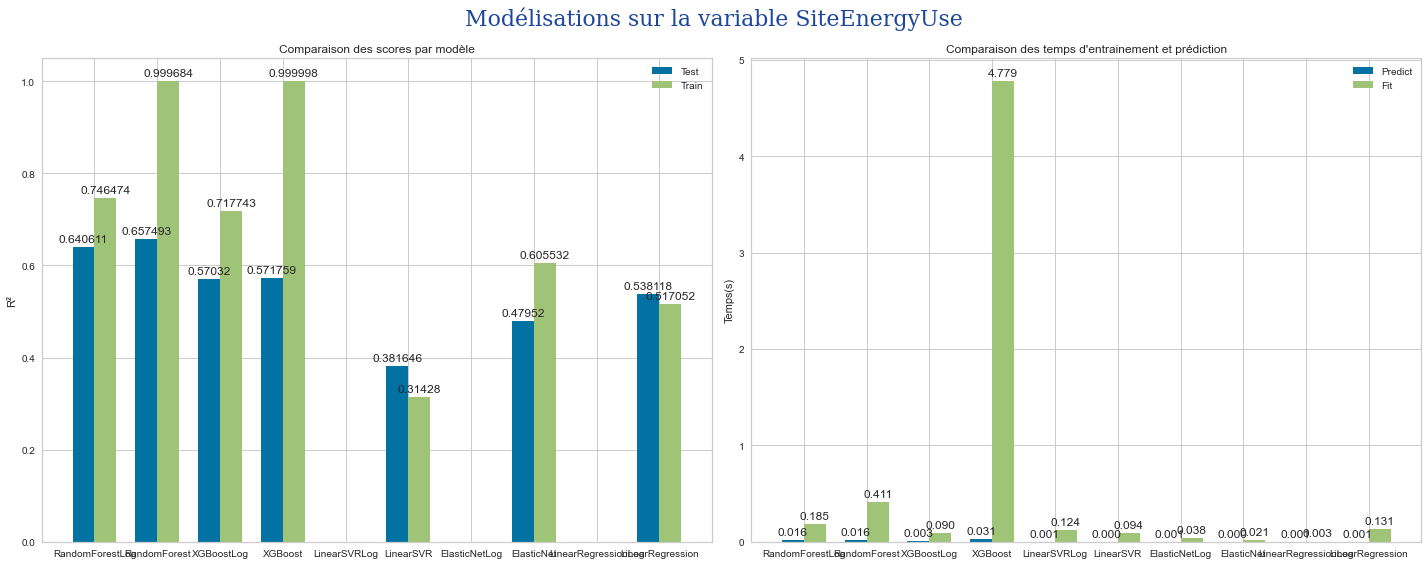

In [137]:
SEU_final_metrics_compare = SEU_final_metrics_compare[SEU_final_metrics_compare > 0]
x = np.arange(len(SEU_final_metrics_compare.index))
width = 0.35

fig, ax = plt.subplots(1,2,figsize=(20,8), sharey=False, sharex=False)

scores1 = ax[0].bar(x - width/2, SEU_final_metrics_compare['mean_test_score'], width, label='Test')
scores2 = ax[0].bar(x + width/2, SEU_final_metrics_compare['mean_train_score'], width, label='Train')
ax[0].set_ylabel('R²')
ax[0].set_title('Comparaison des scores par modèle')
ax[0].set_xticks(x)
ax[0].set_xticklabels(SEU_final_metrics_compare.index)
ax[0].legend()
ax[0].bar_label(scores1, padding=3)
ax[0].bar_label(scores2, padding=3)

times1 = ax[1].bar(x - width/2, SEU_final_metrics_compare['mean_score_time'], width, label='Predict')
times2 = ax[1].bar(x + width/2, SEU_final_metrics_compare['mean_fit_time'], width, label='Fit')
ax[1].set_ylabel('Temps(s)')
ax[1].set_title("Comparaison des temps d'entrainement et prédiction")
ax[1].set_xticks(x)
ax[1].set_xticklabels(SEU_final_metrics_compare.index)
ax[1].legend()
ax[1].bar_label(times1, padding=3, fmt='%.3f')
ax[1].bar_label(times2, padding=3, fmt='%.3f')

plt.suptitle("Modélisations sur la variable SiteEnergyUse", fontdict=font_title, fontsize=22)
fig.tight_layout()

plt.show()

Pour la variable SiteEnergyUse, les modèles RandomForest offrent à nouveau les meilleurs scores R². Comparons ces modèles pour déterminer lequel choisir pour prédire la variable SiteEnergyUse.

### Avec Transformation Log

In [138]:
SEU_rfr_model.named_steps['grid_search_rfr'].best_params_

{'model__regressor__bootstrap': False,
 'model__regressor__max_depth': 15,
 'model__regressor__max_features': 'log2',
 'model__regressor__min_samples_leaf': 2,
 'model__regressor__min_samples_split': 2,
 'select__k': 3,
 'select__score_func': <function sklearn.feature_selection._univariate_selection.f_regression(X, y, *, center=True)>}

In [243]:

pipe = Pipeline([
('select', SelectKBest(f_regression, k=3)),
('model', TransformedTargetRegressor(
                                regressor=RandomForestRegressor(bootstrap= False,
                                                               max_depth=15,
                                                               max_features='log2',
                                                               min_samples_leaf=2,
                                                               min_samples_split=2,
                                                               random_state=42), 
                                func=np.log, 
                                inverse_func=np.exp))])
rfr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_rfr',pipe)])
SEU_rfr_model_final = rfr_grid_cv.fit(X_train, y_train['SiteEnergyUse(kBtu)'])


Regardons la learning Curve

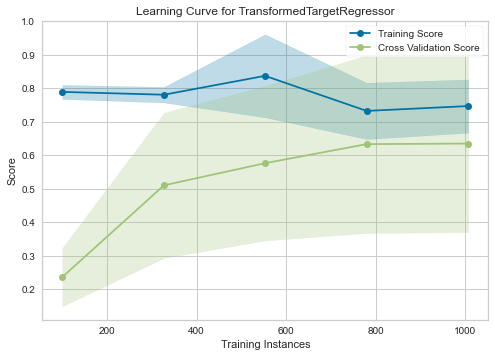

<AxesSubplot:title={'center':'Learning Curve for TransformedTargetRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [140]:
visualizer = LearningCurve(SEU_rfr_model_final, scoring='r2',cv=5)

visualizer.fit(X_train, y_train["SiteEnergyUse(kBtu)"])        # Fit the data to the visualizer
visualizer.show() 

- Pour la taille des données d'entraînement **inférieure à 800**, la différence entre le training score et le validation score est bien plus grande. C'est le cas d'un **overfitting (Variance élevée)**
- Pour la taille des données d'entraînement **supérieure à 800, le modèle est meilleur**.


Dans notre cas, nous en avons plus de 800 donc notre modèle ne présente aucun cas d'overfitting ou underfitting.

### Sans Transformation Log

In [142]:
SEU_rfr_model_nolog.named_steps['grid_search_rfr_nolog'].best_params_

{'model__bootstrap': False,
 'model__max_depth': 15,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'select__k': 11,
 'select__score_func': <function sklearn.feature_selection._univariate_selection.f_regression(X, y, *, center=True)>}

In [244]:

pipe = Pipeline([
('select', SelectKBest(f_regression, k=11)),
('model', RandomForestRegressor(max_depth = 15,
                                bootstrap = False,
                                max_features='sqrt',
                                min_samples_leaf = 1,
                                min_samples_split = 2,
                                random_state=42
                               ))])
rfr_grid_cv_nolog = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_rfr_nolog', pipe)])
SEU_rfr_model_nolog_final = rfr_grid_cv_nolog.fit(X_train, y_train['SiteEnergyUse(kBtu)'])


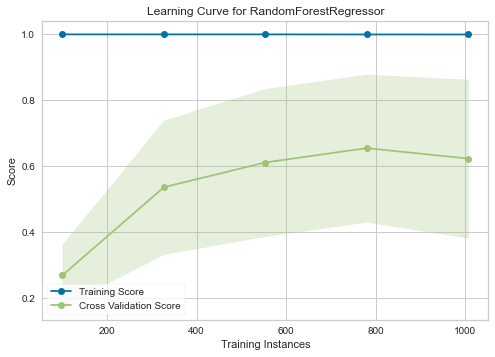

<AxesSubplot:title={'center':'Learning Curve for RandomForestRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [144]:
from yellowbrick.model_selection import LearningCurve

visualizer = LearningCurve(SEU_rfr_model_nolog_final, scoring='r2',cv=5)

visualizer.fit(X_train, y_train["SiteEnergyUse(kBtu)"])        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

Le modèle RandomForestRegressor avec transformation LOG est plus performant car il n'overfit pas comparé au modèle sans LOG.

Choisissons le modèle **RandomForestRegressor avec transformation LOG**

Nous allons à présent visualiser l'impact des hyperparamètres de la GridSearch :

In [145]:
 grid = SEU_rfr_model.named_steps['grid_search_rfr']

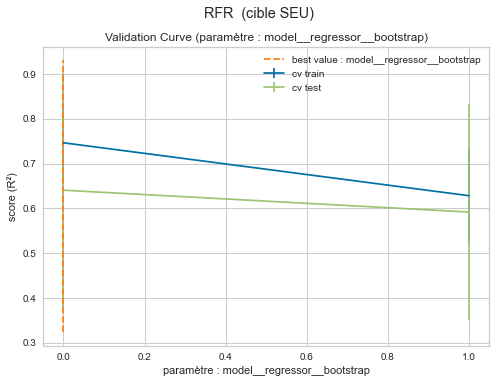

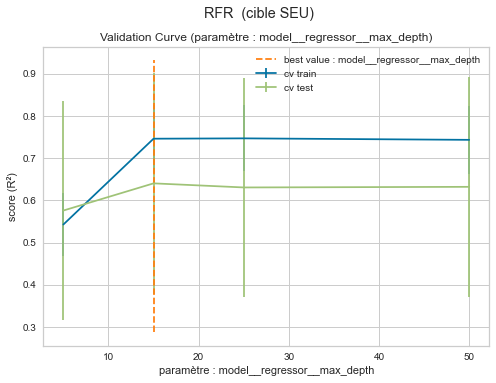

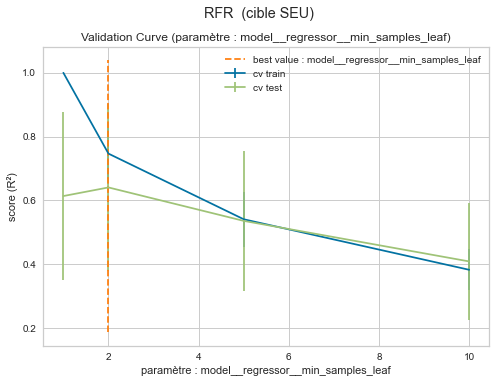

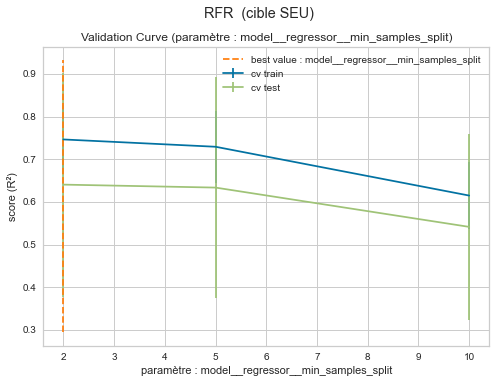

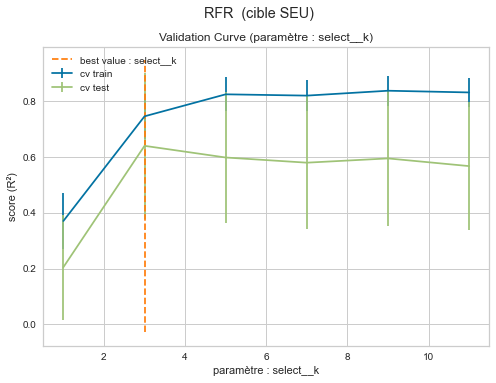

In [146]:
for param in grid.best_params_:
        plot_best_param_scores(grid,param=param, model_name= "RFR",cible="SEU")
        plt.show()


Nous avons à présent défini notre modèle (avec LOG) pour la prédiction de la consommation en énergie. 

Regardons à présent l'importance des variables dans notre modèle de forêts aléatoires :


In [148]:
filter = SEU_rfr_model_final.named_steps['grid_search_rfr'].named_steps['select'].get_support()
features = np.array(X_train.columns)
 

print("All features:")
print(features)
 

print("Selected best {}:".format(len(features[filter])))
print(features[filter])

All features:
['BuildingType' 'PrimaryPropertyType' 'Neighborhood'
 'LargestPropertyUseType' 'NumberofBuildings' 'NumberofFloors'
 'PropertyGFATotal' 'BuildingAge' 'TotalUseTypeNb' 'GFAPerBuilding'
 'GFAPerFloor' 'harvesine_distance']
Selected best 3:
['LargestPropertyUseType' 'GFAPerBuilding' 'harvesine_distance']


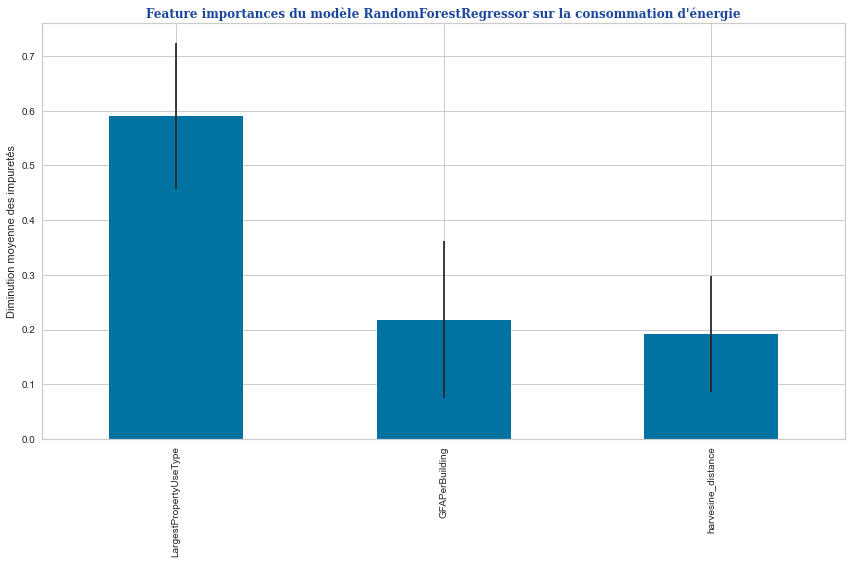

In [149]:
feature_importance = SEU_rfr_model.named_steps['grid_search_rfr'].best_estimator_.named_steps['model'].regressor_.feature_importances_ 
features_names = features[filter]
std = np.std([
    tree.feature_importances_ for tree in SEU_rfr_model.named_steps['grid_search_rfr'].best_estimator_.named_steps['model'].regressor_], axis=0)
df_feature_importance = pd.Series(feature_importance, index=features_names)

fig, ax = plt.subplots(figsize=(12,8))
df_feature_importance.plot.bar( yerr=std,ax=ax)
ax.set_title("Feature importances du modèle RandomForestRegressor sur la consommation d'énergie", fontdict=font_title)
ax.set_ylabel("Diminution moyenne des impuretés")
fig.tight_layout()

Pour les consommations d'énergie, le type d'utilisation principale des bâtiments à ici une importance bien supérieure aux autres variables. Seulement 3 variables ont été sélectionnés.

# <font color="#337da4" id="section_6">6. Test des modèles sélectionnés</font>

Nous allons à présent tester les modèles sélectionnés sur nos données test et vérifier leurs performances.

## <font color="#337da4" id="section_6_1">6.1. Prédiction des émissions de CO2</font>

In [150]:
def metrics_model(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    diff = y_true - y_pred
    r2 = 1-(sum(diff**2)/sum((y_true-np.mean(y_true))**2))
    dict_metrics = {"Métrique":["R²"], "Résultats":[r2]}
    df_metrics = pd.DataFrame(dict_metrics)
    return df_metrics

In [151]:
def plot_pred_true(y_true, y_pred, color=None, title=None):
    names = [y_true, y_pred]
    X_plot = [y_true.min(), y_true.max()]
    fig = plt.figure(figsize=(12,8))
    plt.scatter(y_true, y_pred, c=color, alpha=.6)
    plt.plot(X_plot, X_plot, color='r')
    plt.xlabel("Valeurs réelles")
    plt.ylabel("Valeurs prédites")
    plt.title("Valeurs prédites VS valeurs réelles | Variable {}".format(title), 
              fontdict=font_title, fontsize=18)
    plt.show()

In [225]:
#Modèle avec les meilleurs paramètres pour les émissions de CO2

import time
start_time = time.time()

GHG_pred = GHG_rfr_model_final.predict(X_test)

print("Temps d'execution de l'algorithme : {:.2} s.".format((time.time() - start_time)))



Temps d'execution de l'algorithme : 0.026 s.


In [226]:
#Calcul des métriques pour les émissions de CO2
GHGmetrics = metrics_model(y_test['TotalGHGEmissions'],GHG_pred)
GHGmetrics

,Métrique,Résultats
0,R²,0.442619




Le R² sur le jeu de données de test s'est un peu dégradé comparativement aux métriques obtenues avec la GridSearch avec le modèle de RandomForestRegressor. Nous allons vérifier la distribution des valeurs prédites en fonction des valeurs réélles :


Text(0, 0.5, 'TotalGHGEmissions')

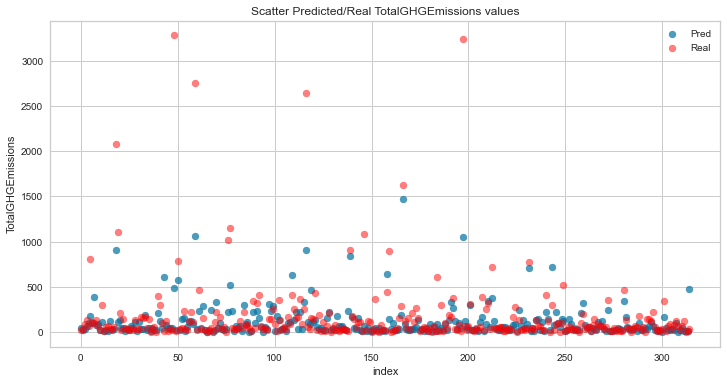

In [228]:
overview_y_pred = GHG_pred
overview_y_test = y_test['TotalGHGEmissions']

overview = pd.DataFrame(data=np.column_stack((overview_y_pred,overview_y_test)),
                        columns=['Predictions','Valeurs Réelles'])
fig, axs = plt.subplots(1, figsize=(12, 6))
axs.scatter(overview["Predictions"].index,overview["Predictions"],alpha=0.7)
axs.scatter(overview["Valeurs Réelles"].index,overview["Valeurs Réelles"],c="red",alpha=0.5)
plt.legend(["Pred","Real"])
plt.title("Scatter Predicted/Real TotalGHGEmissions values")
plt.xlabel("index")
plt.ylabel("TotalGHGEmissions")

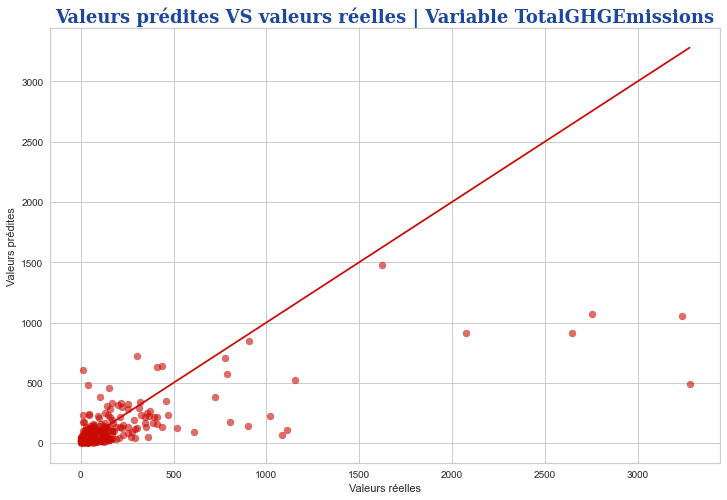

In [242]:
#Affichage des valeurs prédites vs valeurs réélles pour émissions de CO2
plot_pred_true(y_test['TotalGHGEmissions'],GHG_pred, color='r', title="TotalGHGEmissions")



Les valeurs prédites sont un peu éloignées de la première bissectrice. En effet, le transformer log() / exp() de notre variable Y amplifie les erreurs lors de la transformation inverse.

Les mauvais résultats obtenus peuvent dépendre du faible nombre de données qui impactent le Train_Test_Split initial. Le modèle est correctement entrainé mais n'obtient pas les meilleurs résultats sur le jeu de test (pas d'overfiting constaté dans les entrainements).


In [230]:
final_GHG_test = pd.concat([X_test,y_test],axis=1)
final_GHG_test['GHG_pred'] = GHG_pred
compare_final_GHG_test = final_GHG_test = final_GHG_test.groupby(by='BuildingType').mean()

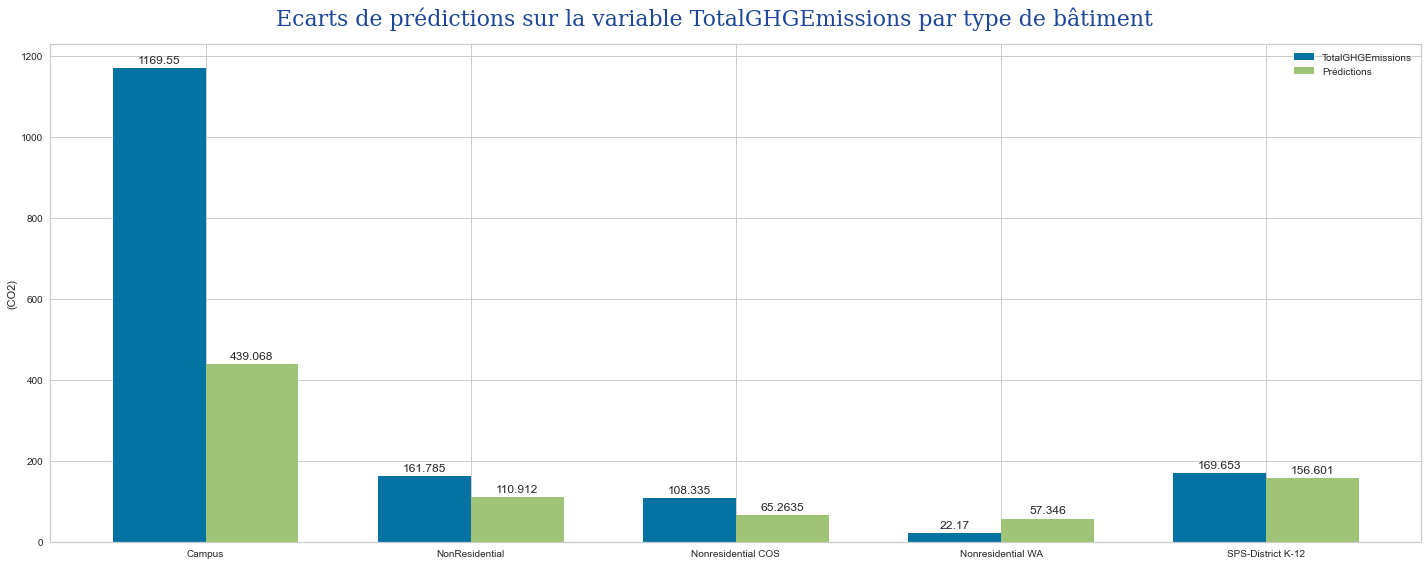

In [231]:
x = np.arange(len(compare_final_GHG_test.index))
width = 0.35

fig, ax = plt.subplots(figsize=(20,8), sharey=False, sharex=False)

scores1 = ax.bar(x - width/2, compare_final_GHG_test['TotalGHGEmissions'], width, label='TotalGHGEmissions')
scores2 = ax.bar(x + width/2, compare_final_GHG_test['GHG_pred'], width, label='Prédictions')
ax.set_ylabel('(CO2)')
ax.set_xticks(x)
ax.set_xticklabels(compare_final_GHG_test.index)
ax.legend()
ax.bar_label(scores1, padding=3)
ax.bar_label(scores2, padding=3)

plt.suptitle("Ecarts de prédictions sur la variable TotalGHGEmissions par type de bâtiment", fontdict=font_title, fontsize=22)
fig.tight_layout()

plt.show()



L'écart est très important sur la catégorie "Campus" qui est faiblement représentée dans le jeu de données mais qui présente les plus grandes consommations.


## <font color="#337da4" id="section_6_2">6.2. Prédiction des consommations d'énergie</font>

In [245]:
start_time = time.time()

SEU_pred = SEU_rfr_model_final.predict(X_test)

print("Temps d'execution de l'algorithme : {:.2} s.".format((time.time() - start_time)))

Temps d'execution de l'algorithme : 0.025 s.


In [246]:
#Calcul des métriques pour les émissions de CO2
SEUmetrics = metrics_model(y_test['SiteEnergyUse(kBtu)'],SEU_pred)
SEUmetrics

,Métrique,Résultats
0,R²,0.621746


Text(0, 0.5, 'SiteEnergyUse(kBtu)')

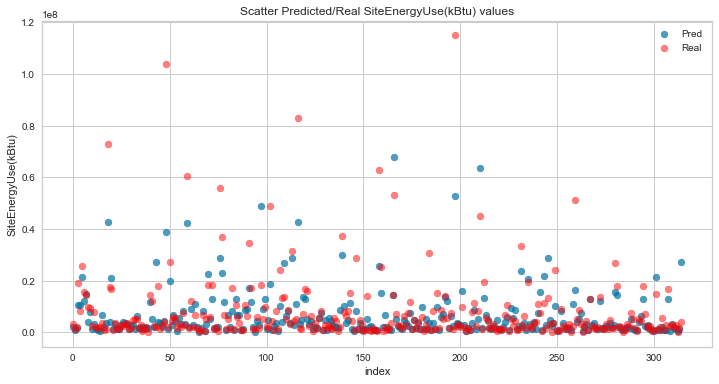

In [247]:
overview_y_pred = SEU_pred
overview_y_test = y_test['SiteEnergyUse(kBtu)']

overview = pd.DataFrame(data=np.column_stack((overview_y_pred,overview_y_test)),
                        columns=['Predictions','Valeurs Réelles'])
fig, axs = plt.subplots(1, figsize=(12, 6))
axs.scatter(overview["Predictions"].index,overview["Predictions"],alpha=0.7)
axs.scatter(overview["Valeurs Réelles"].index,overview["Valeurs Réelles"],c="red",alpha=0.5)
plt.legend(["Pred","Real"])
plt.title("Scatter Predicted/Real SiteEnergyUse(kBtu) values")
plt.xlabel("index")
plt.ylabel("SiteEnergyUse(kBtu)")

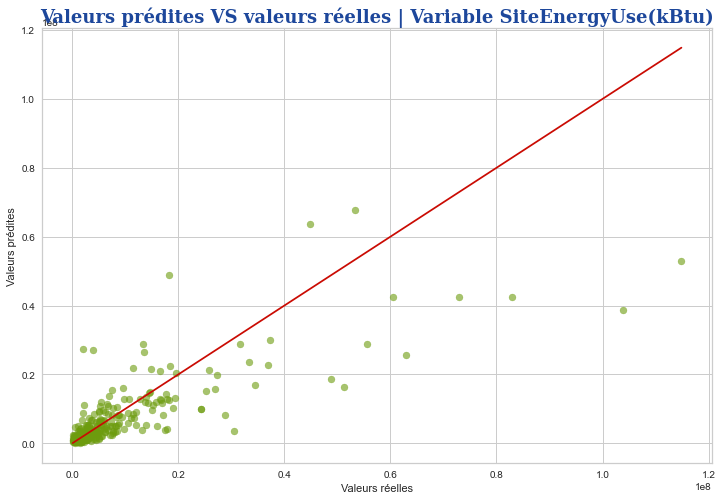

In [248]:
#Affichage des valeurs prédites vs valeurs réélles pour la consommation d'énergie
plot_pred_true(y_test['SiteEnergyUse(kBtu)'],SEU_pred, color="#6D9C0E", title="SiteEnergyUse(kBtu)")

Le modèle est performant en entrainement et arrive à généraliser sur le jeu de test.

Nous allons regarder les écarts de prédiction en fonction du type de bâtiment pour vérifier si des écarts sont plus importants dans certaines catégories :


In [249]:
final_SEU_test = pd.concat([X_test,y_test],axis=1)
final_SEU_test['SEU_pred'] = SEU_pred
compare_final_SEU_test = final_SEU_test = final_SEU_test.groupby(by='BuildingType').mean()

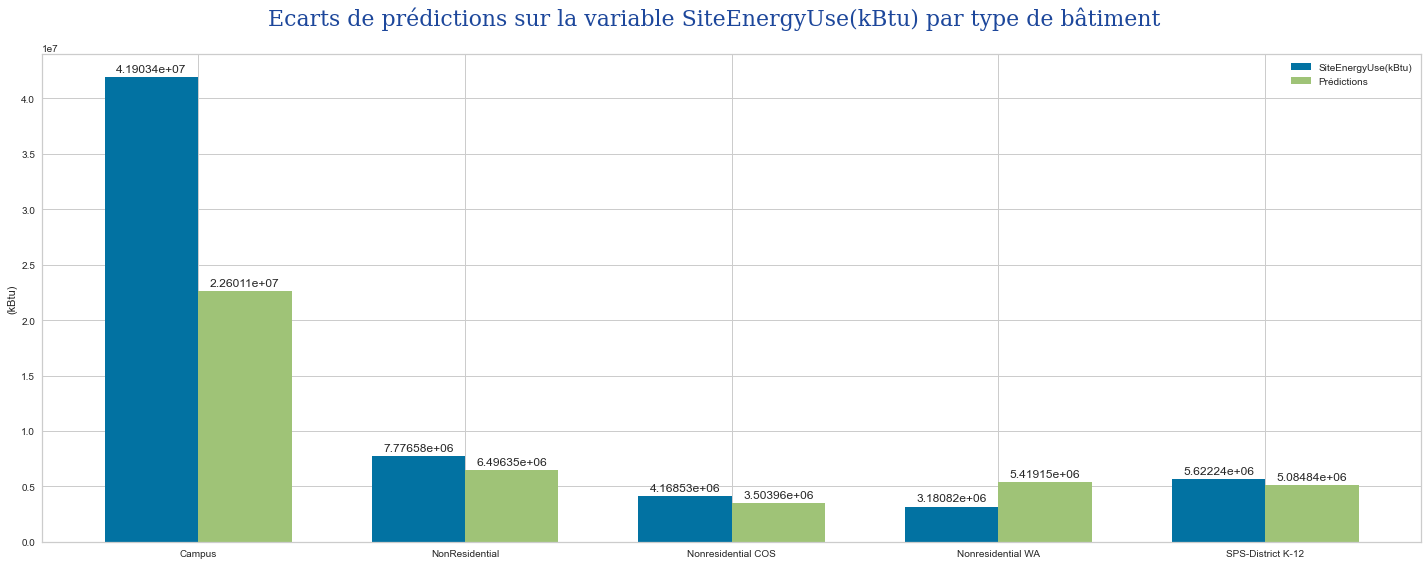

In [250]:
x = np.arange(len(compare_final_SEU_test.index))
width = 0.35

fig, ax = plt.subplots(figsize=(20,8), sharey=False, sharex=False)

scores1 = ax.bar(x - width/2, compare_final_SEU_test['SiteEnergyUse(kBtu)'], width, label='SiteEnergyUse(kBtu)')
scores2 = ax.bar(x + width/2, compare_final_SEU_test['SEU_pred'], width, label='Prédictions')
ax.set_ylabel('(kBtu)')
ax.set_xticks(x)
ax.set_xticklabels(compare_final_SEU_test.index)
ax.legend()
ax.bar_label(scores1, padding=3)
ax.bar_label(scores2, padding=3)

plt.suptitle("Ecarts de prédictions sur la variable SiteEnergyUse(kBtu) par type de bâtiment", fontdict=font_title, fontsize=22)
fig.tight_layout()

plt.show()



L'écart est très important sur la catégorie "Campus" qui est faiblement représentée dans le jeu de données mais qui présente les plus grandes consommations.


# <font color="#337da4" id="section_7">7. Influence du score ENERGY STAR</font>

Le score ENERGY STAR fournit un aperçu complet de la performance énergétique d'un bâtiment, en tenant compte des actifs physiques, des opérations et du comportement des occupants du bâtiment. Il est exprimé sur une échelle de 1 à 100 facile à comprendre : plus le score est élevé, meilleure est la performance énergétique du bâtiment.

Ce score permet de réaliser plusieurs actions :

   - Évaluer les données énergétiques réelles facturées,
   - Normaliser pour l'activité commerciale (heures, travailleurs, climat),
   - Comparer les bâtiments à la population nationale,
   - Indiquer le niveau de performance énergétique.

Nous allons donc évaluer si ce score à un impact significatif sur les performances de notre modélisation.

In [251]:
#Ajout de la variable à nos variables X
X['energystar_score'] = energystar_score
#Ajout de la variable dans les variables numérique du preprocessor
numeric_features.append('energystar_score')



In [252]:
#Filtrage des données ayant un Energy Star Score renseigné
X = X[X['energystar_score'].isnull()==False]
Y = y[y.index.isin(list(X.index))]

Regardons la distribution de cette variable ainsi que sa relation avec les émissions de CO2 :


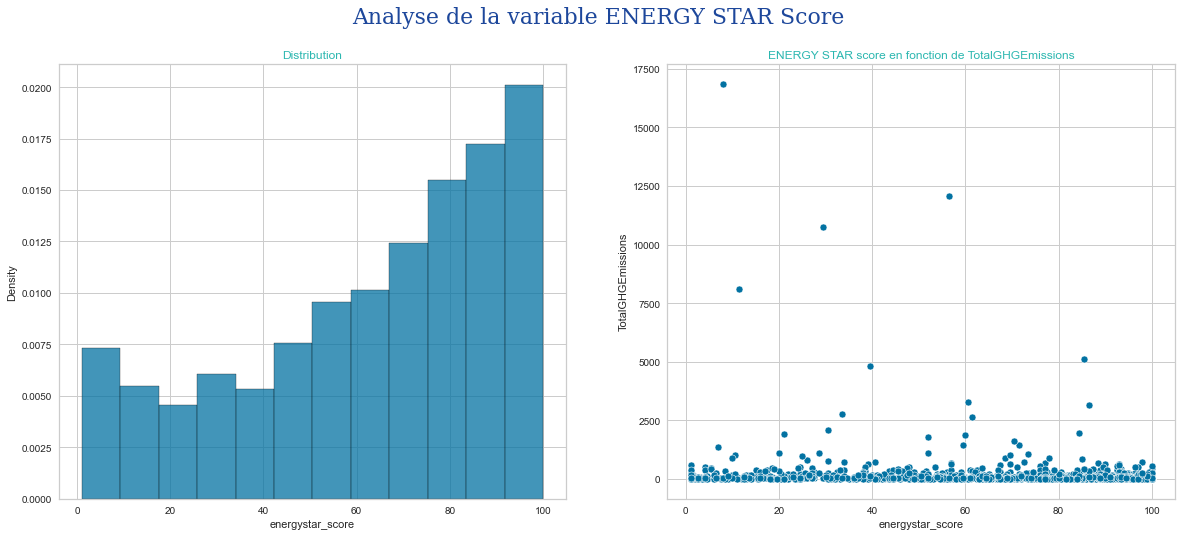

In [253]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=X, x='energystar_score', stat="density", ax=axes[0])
axes[0].set_title("Distribution", color='#2cb7b0')
sns.scatterplot(data=pd.concat([X,Y], axis=1), y='TotalGHGEmissions', x='energystar_score', ax=axes[1])
axes[1].set_title("ENERGY STAR score en fonction de TotalGHGEmissions", color='#2cb7b0')
plt.suptitle("Analyse de la variable ENERGY STAR Score", fontdict=font_title, fontsize=22)
plt.show()

On remarque ici que le score ENERGY STAR ne semble pas avoir de corrélation importante avec les émissions de CO2. La distribution ne suit pas de loi normale et la majorité des batiments a un score supérieur à 50 (de bonne qualité voire de très bonne qualité).


In [254]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 833 lignes,
Test: 209 lignes.



### Le fait de rajouter une variable dans le dataset, remet en cause le modèle et ses hyperparamètres. 

Pour prouver cette affirmation :
   1. On utilisera le meilleur modèle calculé sur la variable TotalGHGEmissions en incluant l'ENERGY STAR Score
   2. On utilisera le meilleur modèle précédent et procéderons au GridSearchCV 


#### **7.1.1. Le meilleur modèle calculé sur la variable TotalGHGEmissions en incluant l'ENERGY STAR Score**

In [282]:

pipe = Pipeline([
('select', SelectKBest(f_regression, k=3)),
('model', TransformedTargetRegressor(
                                regressor=RandomForestRegressor(bootstrap= False,
                                                               max_depth=15,
                                                               max_features='log2',
                                                               min_samples_leaf=2,
                                                               min_samples_split=2,
                                                               random_state=42), 
                                func=np.log, 
                                inverse_func=np.exp))])
rfr_grid_cv_eStar1 = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_rfr_eStar',pipe)])

GHG_rfr_model_eStar1 = rfr_grid_cv_eStar1.fit(X_train, y_train['TotalGHGEmissions'])
#GHG_rfr_results_eStar1 = model_scores(GHG_rfr_model_eStar1, 'grid_search_rfr_eStar')

In [283]:
#Calcul des métriques pour les émissions de CO2
GHGmetrics1 = GHGmetrics.copy()

In [284]:
GHG_pred_star1 = GHG_rfr_model_eStar1.predict(X_test)
#Calcul des métriques pour les émissions de CO2
GHGmetricsES1 = metrics_model(y_test['TotalGHGEmissions'],GHG_pred_star1)
GHGmetrics1 = GHGmetrics1.rename(columns={"Résultats" : "Sans ENERGY STAR"})
GHGmetrics1['Avec ENERGY STAR'] = GHGmetricsES1['Résultats']
GHGmetrics1

,Métrique,Sans ENERGY STAR,Avec ENERGY STAR
0,R²,0.442619,0.169185


Il y a une nette dégradation de la performance du modèle en incluant l'ENERGYSTAR SCORE.

Regardons ses features importances :

In [285]:
filter = GHG_rfr_model_eStar1.named_steps['grid_search_rfr_eStar'].named_steps['select'].get_support()
features = np.array(X_train.columns)
 

print("All features:")
print(features)
 

print("Selected best {}:".format(len(features[filter])))
print(features[filter])

All features:
['BuildingType' 'PrimaryPropertyType' 'Neighborhood'
 'LargestPropertyUseType' 'NumberofBuildings' 'NumberofFloors'
 'PropertyGFATotal' 'BuildingAge' 'TotalUseTypeNb' 'GFAPerBuilding'
 'GFAPerFloor' 'harvesine_distance' 'energystar_score']
Selected best 3:
['GFAPerBuilding' 'GFAPerFloor' 'energystar_score']


Les features importances ne sont plus les mêmes;
- Modele Sans ESS : LargestPropertyUseType , GFAPerBuilding et harvesine_distance
- Avec ESS : 'GFAPerBuilding' 'GFAPerFloor' 'energystar_score'

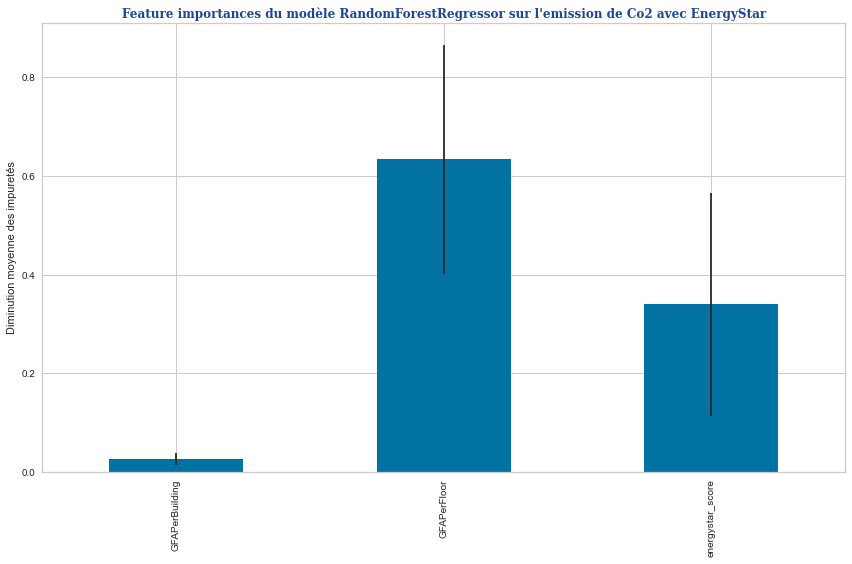

In [288]:
feature_importance = GHG_rfr_model_eStar1.named_steps['grid_search_rfr_eStar'].named_steps['model'].regressor_.feature_importances_ 
features_names = features[filter]
std = np.std([
    tree.feature_importances_ for tree in GHG_rfr_model_eStar1.named_steps['grid_search_rfr_eStar'].named_steps['model'].regressor_], axis=0)
df_feature_importance = pd.Series(feature_importance, index=features_names)

fig, ax = plt.subplots(figsize=(12,8))
df_feature_importance.plot.bar( yerr=std,ax=ax)
ax.set_title("Feature importances du modèle RandomForestRegressor sur l'emission de Co2 avec EnergyStar", fontdict=font_title)
ax.set_ylabel("Diminution moyenne des impuretés")
fig.tight_layout()

La surface au sol par étage  et l'ESS ont un poids plus important dans la décision de ce modèle.

Nous allons à présent visualiser l'impact des hyperparamètres de la GridSearch du modèle sans ESS:

In [292]:
grid = GHG_rfr_model.named_steps['grid_search_rfr']

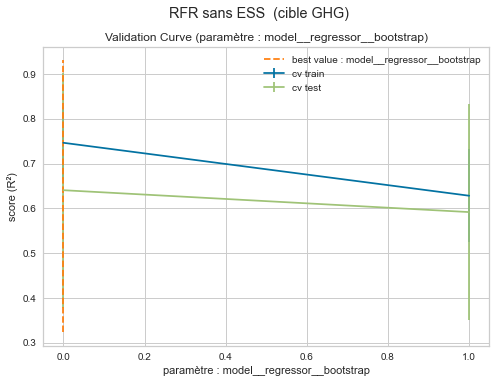

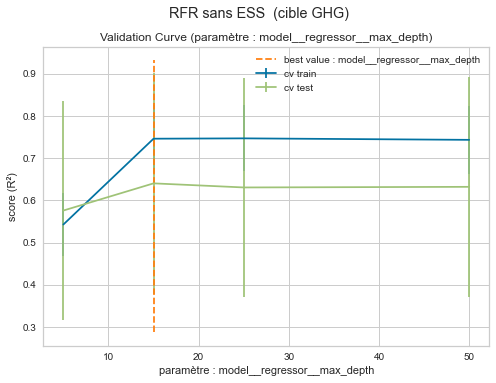

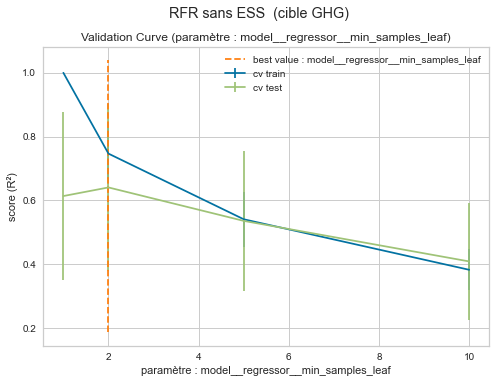

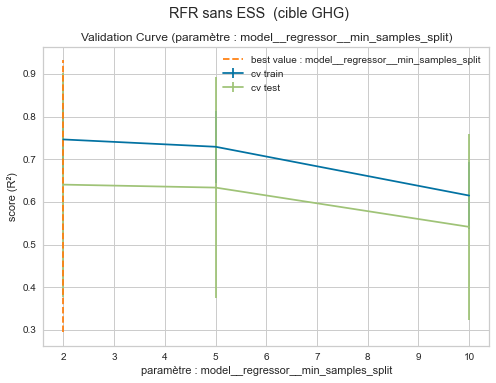

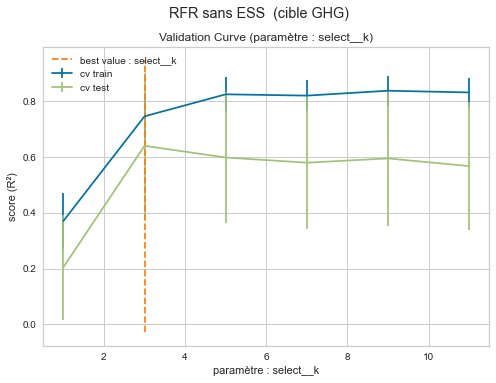

In [294]:
for param in grid.best_params_:
        plot_best_param_scores(grid,param=param, model_name= "RFR sans ESS",cible="GHG")
        plt.show()

#### **7.1.2. Pour prouver que l'ESS a une influence sur les prédictions des émission de CO2, nous devons créer un nouveau modèle :**
 - Choisissons le meilleur modèle précédent et procédons au GridSearchCV
 - S'il y a une différence de la performance, cela prouvera que si l'on ajoute, ne serait ce qu'une variable, le modèle sera obsolète.

In [255]:
param_rfr = {'select__k': np.arange(1,X_test.shape[1]+1,2),
             'select__score_func': [mutual_info_regression, f_regression],
             'model__regressor__max_features' : ['sqrt', 'log2'],
             'model__regressor__max_depth': [5, 15, 25, 50],
             'model__regressor__min_samples_split': [2, 5, 10],
             'model__regressor__bootstrap' : [True, False],
             'model__regressor__min_samples_leaf': [1,2,5,10]}
pipe = Pipeline([
('select', SelectKBest()),
('model', TransformedTargetRegressor(
                                regressor=RandomForestRegressor(random_state=42), 
                                func=np.log, 
                                inverse_func=np.exp))])
rfr_grid_cv_eStar = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_rfr_eStar', GridSearchCV(pipe,
                            param_grid=param_rfr,
                            cv=5,
                            scoring=('r2'),
                            refit="r2",
                            return_train_score = True,
                            n_jobs = -1))])

GHG_rfr_model_eStar = rfr_grid_cv_eStar.fit(X_train, y_train['TotalGHGEmissions'])
GHG_rfr_results_eStar = model_scores(GHG_rfr_model_eStar, 'grid_search_rfr_eStar')

Meilleur Score R2 : 0.475
Meilleurs paramètres : {'model__regressor__bootstrap': False, 'model__regressor__max_depth': 50, 'model__regressor__max_features': 'sqrt', 'model__regressor__min_samples_leaf': 1, 'model__regressor__min_samples_split': 2, 'select__k': 7, 'select__score_func': <function f_regression at 0x000002009940BB80>}
Temps moyen d'entrainement : 188.96s


In [256]:
GHG_pred_star = GHG_rfr_model_eStar.predict(X_test)
#Calcul des métriques pour les émissions de CO2
GHGmetricsES = metrics_model(y_test['TotalGHGEmissions'],GHG_pred_star)
GHGmetrics = GHGmetrics.rename(columns={"Résultats" : "Sans ENERGY STAR"})
GHGmetrics['Avec ENERGY STAR'] = GHGmetricsES['Résultats']
GHGmetrics

,Métrique,Sans ENERGY STAR,Avec ENERGY STAR
0,R²,0.442619,0.71081


In [257]:
filter = GHG_rfr_model_eStar.named_steps['grid_search_rfr_eStar'].best_estimator_.named_steps['select'].get_support()
features = np.array(X_train.columns)
 

print("All features:")
print(features)
 

print("Selected best {}:".format(len(features[filter])))
print(features[filter])

All features:
['BuildingType' 'PrimaryPropertyType' 'Neighborhood'
 'LargestPropertyUseType' 'NumberofBuildings' 'NumberofFloors'
 'PropertyGFATotal' 'BuildingAge' 'TotalUseTypeNb' 'GFAPerBuilding'
 'GFAPerFloor' 'harvesine_distance' 'energystar_score']
Selected best 7:
['PrimaryPropertyType' 'LargestPropertyUseType' 'PropertyGFATotal'
 'BuildingAge' 'GFAPerBuilding' 'GFAPerFloor' 'energystar_score']


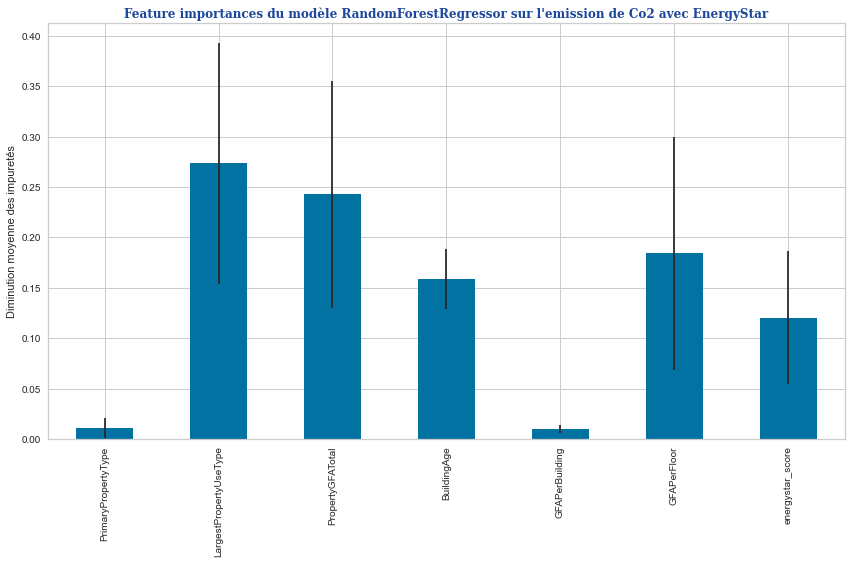

In [258]:
feature_importance = GHG_rfr_model_eStar.named_steps['grid_search_rfr_eStar'].best_estimator_.named_steps['model'].regressor_.feature_importances_ 
features_names = features[filter]
std = np.std([
    tree.feature_importances_ for tree in GHG_rfr_model_eStar.named_steps['grid_search_rfr_eStar'].best_estimator_.named_steps['model'].regressor_], axis=0)
df_feature_importance = pd.Series(feature_importance, index=features_names)

fig, ax = plt.subplots(figsize=(12,8))
df_feature_importance.plot.bar( yerr=std,ax=ax)
ax.set_title("Feature importances du modèle RandomForestRegressor sur l'emission de Co2 avec EnergyStar", fontdict=font_title)
ax.set_ylabel("Diminution moyenne des impuretés")
fig.tight_layout()

Comme pour le modèle sans la variable EnergyStar : les surfaces (GFA) de la propriété et le type d'utilisation principale ont un poids plus important dans les décisions du modèle. Cependant les coordonnées géographiques n'ont pas cette fois ci été sélectionné. L'âge des buildings et l'ENERGYStar Score ont été ajouté comme élément important du modèle.

Nous allons à présent visualiser l'impact des hyperparamètres de la GridSearch sur ce nouveau modèle:

In [129]:
def plot_best_param_scores(gs, param='select__k', model_name='', cible="None", logx=False):
    cv = pd.DataFrame.from_dict(gs.cv_results_)
    param_key = f'param_{param}'
    if not param_key in cv.columns:
        return

    # filter by all best params, except chosen param
    filtre = cv.index==cv.index
    best_param = gs.best_params_[param]
    if not isinstance(best_param, (int, float,np.int64,np.float64,np.int32,np.float32)):
        # param is not a number
        return
    for key in gs.best_params_.keys():
        #print(f'key={key}, param_key={param_key}')
        if key != param:
            filtre &= cv[f'param_{key}'] == gs.best_params_[key]

    res = cv[filtre]
    if len(res)<0:
        return
    if 'mean_train_score' in res.columns:
        plt.errorbar(x=res[param_key], y=res['mean_train_score'],
            yerr=res['std_train_score'], label='cv train')
    plt.errorbar(x=res[param_key], y=res['mean_test_score'],
                 yerr=res['std_test_score'], label='cv test')
    ax = plt.gca()

    y_min, y_max = plt.ylim()
    ax.vlines(best_param, y_min, y_max,
              label=f'best value : {param}', linestyle="--", color="tab:orange")
    plt.legend()
    plt.xlabel(f'paramètre : {param}')
    if  logx:
        plt.xscale('log')
    plt.ylabel('score (R²)')
    plt.suptitle(f'{model_name}  (cible {cible})')
    plt.title(f'Validation Curve (paramètre : {param})')


In [290]:
 grid_eStar = GHG_rfr_model_eStar.named_steps['grid_search_rfr_eStar']

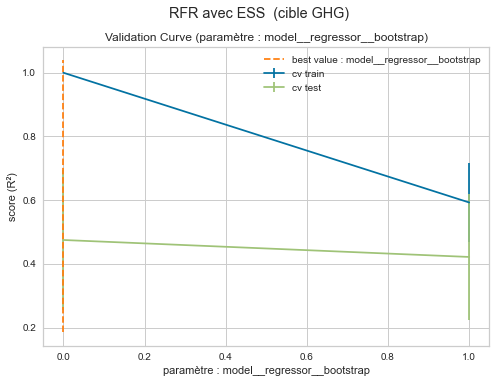

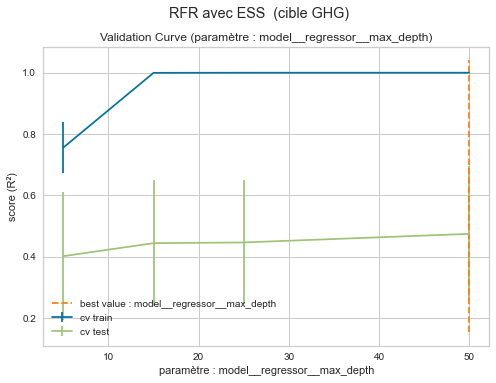

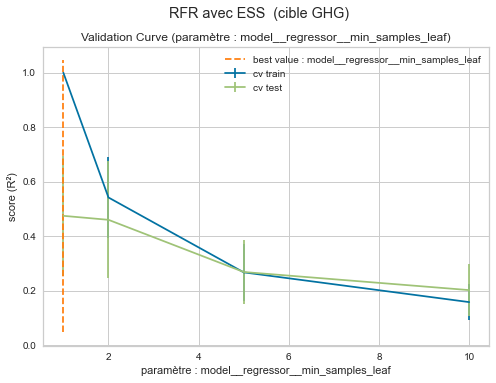

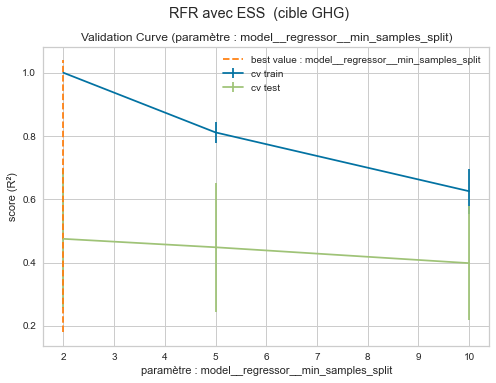

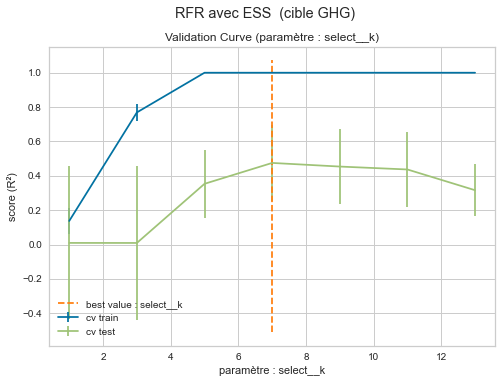

In [291]:
for param in grid.best_params_:
        plot_best_param_scores(grid_eStar,param=param, model_name= "RFR avec ESS",cible="GHG")
        plt.show()

On se focalisant seulement sur le paramètre k de SelectKBest, on remarque que dans le meilleur modèle précédent : 
 - k = 3 et avait la meilleure performance 
 - or ici c'est la pire.

#### Cela prouve que le meilleur modèle précédent est obsolète après l'ajout de l'ESS

## 7.1.3. Prédictions des émissions de CO2 avec le nouveau modèle avec ESS

Text(0, 0.5, 'TotalGHGEmissions')

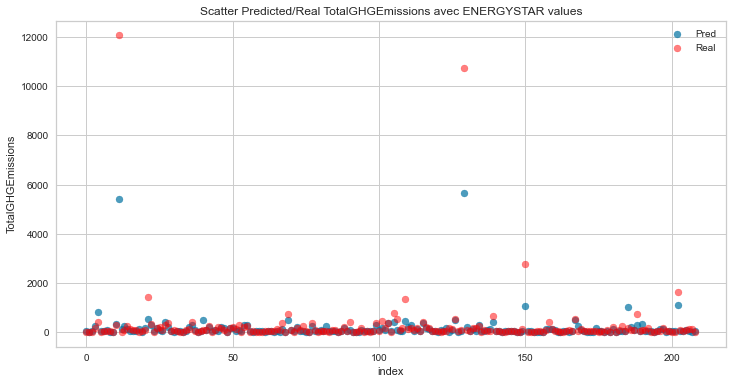

In [260]:
overview_y_pred = GHG_pred_star
overview_y_test = y_test['TotalGHGEmissions']

overview = pd.DataFrame(data=np.column_stack((overview_y_pred,overview_y_test)),
                        columns=['Predictions','Valeurs Réelles'])
fig, axs = plt.subplots(1, figsize=(12, 6))
axs.scatter(overview["Predictions"].index,overview["Predictions"],alpha=0.7)
axs.scatter(overview["Valeurs Réelles"].index,overview["Valeurs Réelles"],c="red",alpha=0.5)
plt.legend(["Pred","Real"])
plt.title("Scatter Predicted/Real TotalGHGEmissions avec ENERGYSTAR values")
plt.xlabel("index")
plt.ylabel("TotalGHGEmissions")

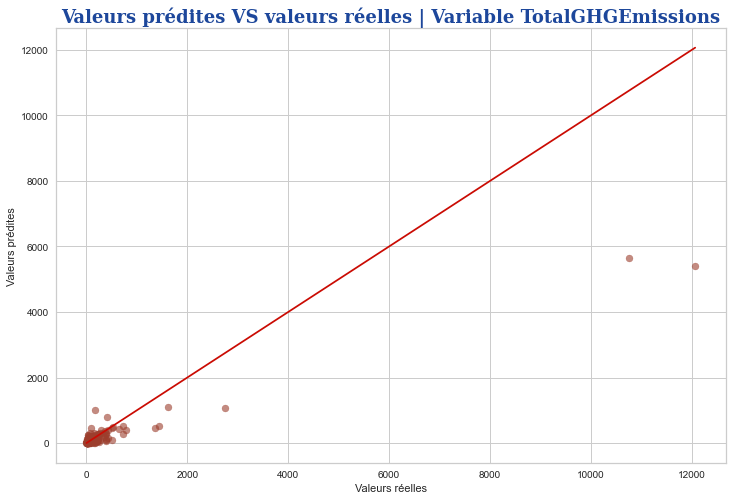

In [259]:
#Affichage des valeurs prédites vs valeurs réélles pour émissions de CO2
plot_pred_true(y_test['TotalGHGEmissions'] ,GHG_pred_star , color="#9C3E2D", title="TotalGHGEmissions")

Les valeurs prédites sont en effet beaucoup plus reserrées sur la première bissectrice et les métriques se sont améliorées grâce à la prise en compte de l'ENERGY STAR Score.

Cette amélioration est rééllement significative, cependant il faut prendre en compte le bénéfice vis à vis du coût de cet ENERGY STAR Score.


---

## 7.2 Prédictions de la consommation énergétique avec le nouveau modèle avec ESS

In [295]:
param_rfr = {'select__k': np.arange(1,X_test.shape[1]+1,2),
             'select__score_func': [mutual_info_regression, f_regression],
             'model__regressor__max_features' : ['sqrt', 'log2'],
             'model__regressor__max_depth': [5, 15, 25, 50],
             'model__regressor__min_samples_split': [2, 5, 10],
             'model__regressor__bootstrap' : [True, False],
             'model__regressor__min_samples_leaf': [1,2,5,10]}
pipe = Pipeline([
('select', SelectKBest()),
('model', TransformedTargetRegressor(
                                regressor=RandomForestRegressor(random_state=42), 
                                func=np.log, 
                                inverse_func=np.exp))])
rfr_grid_cv_eStar = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_rfr_eStar', GridSearchCV(pipe,
                            param_grid=param_rfr,
                            cv=5,
                            scoring=('r2'),
                            refit="r2",
                            return_train_score = True,
                            n_jobs = -1))])

SEU_rfr_model_eStar = rfr_grid_cv_eStar.fit(X_train, y_train['SiteEnergyUse(kBtu)'])
SEU_rfr_results_eStar = model_scores(SEU_rfr_model_eStar, 'grid_search_rfr_eStar')

Meilleur Score R2 : 0.542
Meilleurs paramètres : {'model__regressor__bootstrap': False, 'model__regressor__max_depth': 15, 'model__regressor__max_features': 'sqrt', 'model__regressor__min_samples_leaf': 1, 'model__regressor__min_samples_split': 5, 'select__k': 9, 'select__score_func': <function f_regression at 0x000002009940BB80>}
Temps moyen d'entrainement : 188.62s


In [314]:
SEU_pred_star = SEU_rfr_model_eStar.predict(X_test)
#Calcul des métriques pour les émissions de CO2
SEUmetricsES = metrics_model(y_test['SiteEnergyUse(kBtu)'],SEU_pred_star)
SEUmetrics = SEUmetrics.rename(columns={"Résultats" : "Sans ENERGY STAR"})
SEUmetrics['Avec ENERGY STAR'] = SEUmetricsES['Résultats']
SEUmetrics

,Métrique,Sans ENERGY STAR,Avec ENERGY STAR
0,R²,0.621746,0.72164


In [315]:
filter = SEU_rfr_model_eStar.named_steps['grid_search_rfr_eStar'].best_estimator_.named_steps['select'].get_support()
features = np.array(X_train.columns)
 

print("All features:")
print(features)
 

print("Selected best {}:".format(len(features[filter])))
print(features[filter])

All features:
['BuildingType' 'PrimaryPropertyType' 'Neighborhood'
 'LargestPropertyUseType' 'NumberofBuildings' 'NumberofFloors'
 'PropertyGFATotal' 'BuildingAge' 'TotalUseTypeNb' 'GFAPerBuilding'
 'GFAPerFloor' 'harvesine_distance' 'energystar_score']
Selected best 9:
['PrimaryPropertyType' 'Neighborhood' 'LargestPropertyUseType'
 'NumberofFloors' 'PropertyGFATotal' 'BuildingAge' 'GFAPerBuilding'
 'GFAPerFloor' 'energystar_score']


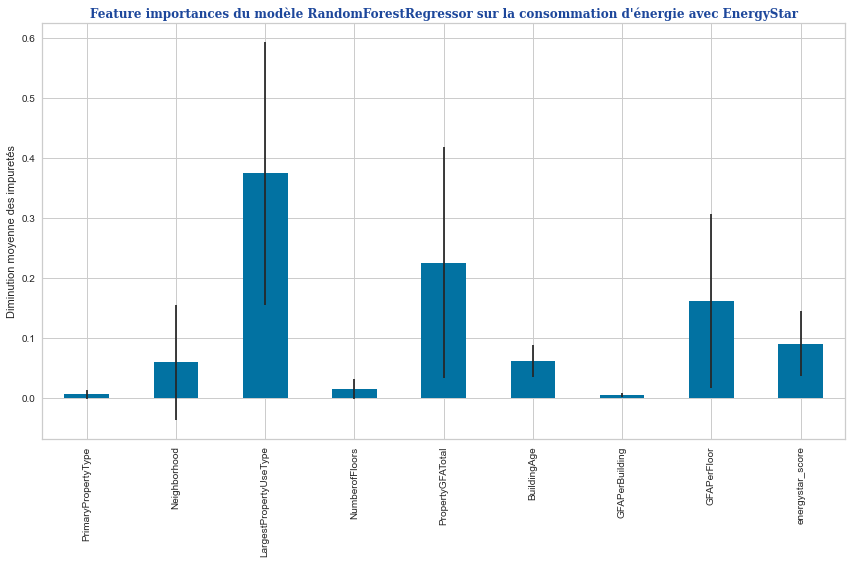

In [316]:
feature_importance = SEU_rfr_model_eStar.named_steps['grid_search_rfr_eStar'].best_estimator_.named_steps['model'].regressor_.feature_importances_ 
features_names = features[filter]
std = np.std([
    tree.feature_importances_ for tree in SEU_rfr_model_eStar.named_steps['grid_search_rfr_eStar'].best_estimator_.named_steps['model'].regressor_], axis=0)
df_feature_importance = pd.Series(feature_importance, index=features_names)

fig, ax = plt.subplots(figsize=(12,8))
df_feature_importance.plot.bar( yerr=std,ax=ax)
ax.set_title("Feature importances du modèle RandomForestRegressor sur la consommation d'énergie avec EnergyStar", fontdict=font_title)
ax.set_ylabel("Diminution moyenne des impuretés")
fig.tight_layout()

Comme pour le modèle sans la variable EnergyStar : les surfaces (GFA) de la propriété et le type d'utilisation principale ont un poids plus important dans les décisions du modèle. Cependant les coordonnées géographiques n'ont pas cette fois ci été sélectionné. L'âge des buildings et l'ENERGYStar Score ont été ajouté comme élément important du modèle.

Text(0, 0.5, 'SiteEnergyUse(kBtu)')

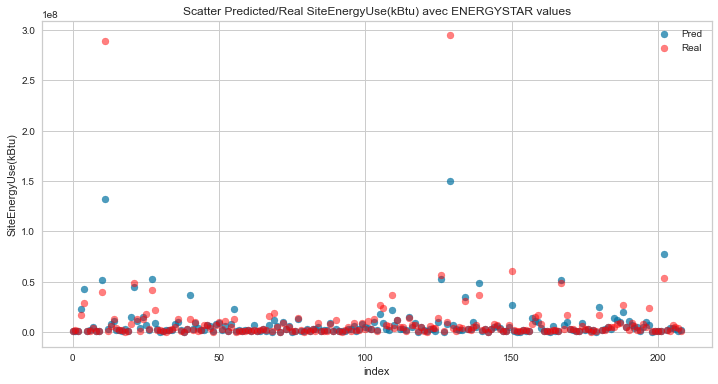

In [317]:
overview_y_pred = SEU_pred_star
overview_y_test = y_test['SiteEnergyUse(kBtu)']

overview = pd.DataFrame(data=np.column_stack((overview_y_pred,overview_y_test)),
                        columns=['Predictions','Valeurs Réelles'])
fig, axs = plt.subplots(1, figsize=(12, 6))
axs.scatter(overview["Predictions"].index,overview["Predictions"],alpha=0.7)
axs.scatter(overview["Valeurs Réelles"].index,overview["Valeurs Réelles"],c="red",alpha=0.5)
plt.legend(["Pred","Real"])
plt.title("Scatter Predicted/Real SiteEnergyUse(kBtu) avec ENERGYSTAR values")
plt.xlabel("index")
plt.ylabel("SiteEnergyUse(kBtu)")

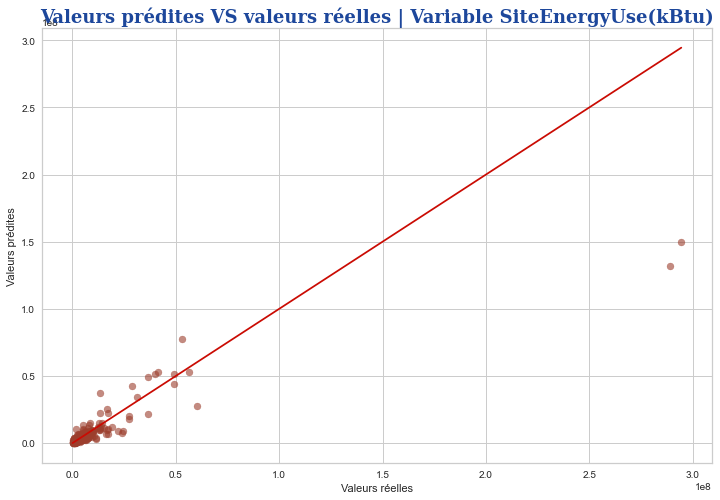

In [318]:
#Affichage des valeurs prédites vs valeurs réélles pour émissions de CO2
plot_pred_true(y_test['SiteEnergyUse(kBtu)'] ,SEU_pred_star , color="#9C3E2D", title="SiteEnergyUse(kBtu)")

Les valeurs prédites sont en effet beaucoup plus resserrées sur la première bissectrice et les métriques se sont améliorées grâce à la prise en compte de l'ENERGY STAR Score.

Cette amélioration est rééllement significative, cependant il faut prendre en compte le bénéfice vis à vis du coût de cet ENERGY STAR Score.


## Améliorations avec plus de temps et données

- Pour obtenir le meilleur modèle, l'idéal serait de tester tous les modèles comme nous l'avons fait sans la variable ESS
- Réduire le nb de catégories,par ex : des utilisations des buildings afin de réduire la complexité des données, ce qui peut :
  - réduire le temps d'entrainement des modèles 
  - éviter l'overfitting
- Création de nouvelles variables en calculant la GFA de chaque utilisation des buildings (catégorie réduite au préalable)
    - Pourquoi? `LargestPropertyUseType` est la variable la plus importante du modèle de prédiction.